In [161]:
import os
import pathlib
import re
import copy
import warnings

from functools import reduce
from sys import getsizeof

import cv2
import xmltodict
import numpy as np
import pandas as pd
import tiffcapture as tc

from tifffile import imsave
from matplotlib import pyplot as pt

%matplotlib inline

In [2]:
POSITION = 40
PROCESS_PI = False
TIME_UNIT_FACTOR = 600
PIXEL_INCH_RATIO = .647
DIAMETER = 15

In [3]:
# path to exit data
exit_dat = '../results/40-47.csv'

In [4]:
track_path = '../test/eli-new-unsync-bf-%d/out-focus/merged/out/tracked/' % POSITION
with open(os.path.join(track_path, 'merged_Tracks.xml')) as fd:
    td = xmltodict.parse(fd.read())
    
with open(os.path.join(track_path, 'merged.xml')) as fd:
    sd = xmltodict.parse(fd.read())
    
ss = pd.read_csv(os.path.join(track_path, 'All Spots statistics.csv'))
ts = pd.read_csv(os.path.join(track_path, 'Track statistics.csv'))
ba = pd.read_csv(os.path.join(track_path, 'Links in tracks statistics.csv'))
sits = pd.read_csv(os.path.join(track_path, 'Spots in tracks statistics.csv'))

## TODO: include the last one file (branch statistics)

In [5]:
caspase_path = "../test/eli-new-unsync-bf-%d/caspase/" % POSITION
caspase_tiff_path = os.path.join(caspase_path, "caspasexy%dc1.tif" % POSITION)
caspase_tiff_sub_path = os.path.join(caspase_path, "caspasexy%dc1_sub.tif" % POSITION)
# tiff_path_intersection = os.path.join(caspase_path, "caspasexy%dc1_inter.tif" % POSITION)

pi_path = "../test/eli-new-unsync-bf-%d/pi/merged" % POSITION
pi_tiff_path = os.path.join(pi_path, "merged.tif")

out_path_pics = "../results/pics/unsyn/"
if not os.path.exists(out_path_pics):
    os.makedirs(out_path_pics)

#  Function Defs and Uses

### Reference-safe key removal

In [6]:
def removekey(d, key):
    """
    Remove a key from a  dictionary without destroying the reference
    to removed object (which might be used by other processes)
    """
    if key in d:
        r = dict(d)
        del r[key]
        return r

### Reconstruct tree from "Links in Track Statistics" file

In [5]:
def parse_trees(links_tab, verbose=False, parse_velocity_displacement=False):
    """
    Given 'links in tab statistics' from TrackMate.
    Construct data structures representing trees ('tree') and
    their branching ('branch') respectively.
    
    -   'tree' contains mapping of TREE_ID (which is the same as
        the id of root's SPOT_ID) to its associated tree.
        Each tree is in turn a map of TREE_BRANCH_ID
        (which is the branch's first spot's SPOT_ID)
        to its branch which is represented as list of SPOT_ID's.
    -   'branch' encodes how the tree is structured. It contains
        mapping of TREE_ID to the branching configuration.
        The branching configuration is encoded as mapping of
        BRANCH_ID to its two children's BRANCH_ID.
    """
    
    links_tab = links_tab.copy()
    links_tab.index = links_tab.SPOT_TARGET_ID

    tree = {}
    branch = {}
    if parse_velocity_displacement:
        velocity = {}
        displacement = {}
        
    for track in links_tab.TRACK_ID.unique():
    
        sub = links_tab[links_tab.TRACK_ID == track]

        this_lines = {}
        this_branches = {}
        if parse_velocity_displacement:
            this_velocities = {}
            this_displacements = {}
        stack = []
    
        groot = sub.iloc[0][3]
        if verbose:
            print("Parsing tree %s" % groot)
        stack.append(groot)
    
        while len(stack) > 0:
        
            root = stack.pop()
            track = [root]
            if parse_velocity_displacement:
                # initial velocity and displacement is always 0
                vel = [0]
                disp = [0]
            
            if verbose:
                print("Parsing subtree %s" % root)
            nsub = sub[sub.SPOT_SOURCE_ID == root]
        
            while nsub.index.size > 0:
                if nsub.index.size == 1:
                    this = nsub.iloc[0][4]
                    track.append(this)
                    if parse_velocity_displacement:
                        vel.append(sub.loc[this]['VELOCITY'])
                        disp.append(sub.loc[this]['DISPLACEMENT'])
                    nsub = sub[sub.SPOT_SOURCE_ID == this]
                else:
                    stack.append(nsub.iloc[0][4])
                    stack.append(nsub.iloc[1][4])
                    this_branches[root] = (nsub.iloc[0][4], nsub.iloc[1][4])
                    if verbose:
                        print("breaking")
                    break
                
            this_lines[root] = track
            if parse_velocity_displacement:
                this_velocities[root] = vel
                this_displacements[root] = disp
            if verbose:
                print("adding branch %s" % root)
    
        if verbose:
            print("Finishing...")
        tree[groot] = this_lines
        branch[groot] = this_branches
        if parse_velocity_displacement:
            velocity[groot] = this_velocities
            displacement[groot] = this_displacements
        
    if parse_velocity_displacement:
        return tree, branch, velocity, displacement
    else:
        return tree, branch

### Extract values measured by TrackMate

In [8]:
def extract_values(tree, spots_tab, colnames, verbose=False):
    """
    Extract varoius measurement values from spots statistics and save it
    in format similar to parsed tree. The list of values to be extracted
    from spots statistics is defined in 'colnames' 
    
    The information will be stored in following format:
    map(TYPE:(TREE_ID:TREE_BRANCH:list(VALUES))
    
    """
    
    vals = {}

    for tr in tree:
    
        if verbose:
            print("extracting values for %s" % tr)
    
        for colname in colnames:
        
            val_tree = {}
        
            for br in tree[tr]:
            
                brkeys = tree[tr][br]
                brvals = [sits[sits.ID == x][colname].values[0] for x in brkeys]
            
                val_tree[br] = brvals
            
            if colname not in vals:
                vals[colname] = {}
            
            vals[colname][tr] = val_tree
            
    return vals

### Plot tree values for a given tree

In [9]:
def plot_tree_value(tree_id, value, tree_values):
    """
    Plot a given value of a given tree over the time
    """
    
    for key in tree_values['POSITION_T'][tree_id]:
    
        pt.plot(tree_values['POSITION_T'][tree_id][key], 
                svals['TOTAL_INTENSITY'][tree_id][key], 
                label="%d" % key)
    
    pt.title("%s of tree %d over time" % (value, tree_id))
    pt.xlabel("Time")
    pt.ylabel("%s" % value)
    frame = pt.gcf()
    frame.set_size_inches(20, 10)

### Recognize slits in contour mask picture (simplified)

In [10]:
def recognize_slits(img, minsize=6000, maxsize=float("inf")):
    """
    Reads contour mask picture and recognizes slits.
    Slit is defined as having size between $minsize and $maxsize
    This is a simplified version of get_contour
    """
    gray= cv2.cvtColor(img,
                       cv2.COLOR_BGR2GRAY)
    im2, contours, hierarchy  = cv2.findContours(gray, 
                                                 cv2.RETR_LIST,
                                                 cv2.CHAIN_APPROX_SIMPLE)
    
    cts = [ct for ct in contours if (cv2.contourArea(ct) > minsize and cv2.contourArea(ct) < maxsize)]
    return cts

### Extract slits, their corresponding area and the area of all contours (slits or not)

In [11]:
def get_contour(contour_mask_path, min_size=7000, max_size=10000):
    """
    Give contour mask picture (created by adjusting contrast/brightness
    followed by RATS and "fill holes" command) detect contours of
    slits annd return:
    - the list of filtered contours
    - the size list of filtered contours
    - the size of all detected contours (for testing purpose)
    """
    
    ## collect contours and wrap into a function

    im = cv2.imread(contour_mask_path)
    gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    im2, contours, hierarchy  = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

    all_cts_area = np.array([cv2.contourArea(x) for x  in contours])

    filtered_cts = []
    filtered_cts_area = []

    for ct in contours:
        ct_area = cv2.contourArea(ct)
        if (ct_area <= max_size) and (ct_area >= min_size):
            filtered_cts.append(ct)
            filtered_cts_area.append(ct_area)
            
    return filtered_cts, filtered_cts_area, all_cts_area


###  Assign cell tree to a contour

In [12]:
def assign_tree_to_contours(tree_values, contours):
    """
    Given tree values and recognized contours, compute:
    
    -   'assocs': table listing recognized slit and the TREE_ID
        of singly-placed cell tree located in the slit
    -   'occupancy': list containing the number of cell trees
        located in a slit. NOTE: the list is not associated with
        ordering encoded in 'assocs'
    """

    occuppancy = {x:0 for x in range(len(contours))}
    cell_trees = []
    slits = []

    for tr in tree_values['POSITION_X'].keys():
    
        cell_trees.append(tr)

        x = tree_values['POSITION_X'][tr][tr][0] / PIXEL_INCH_RATIO
        y = tree_values['POSITION_Y'][tr][tr][0] / PIXEL_INCH_RATIO
    
        counter = 0
        match = 0
        matchloc = None
    
        for ct in cts:
        
            if cv2.pointPolygonTest(ct, (x, y), False) > 0:
                occuppancy[counter] += 1
                matchloc = counter
                match += 1
            counter +=  1
        
        if match == 0:
            slits.append(None)
        elif match == 1:
            slits.append(matchloc)
        else:
            print("Tree %s got too many matches" % tr)
        
    assocs = pd.DataFrame({'CELL_LINE': cell_trees, 'SLIT_ID': slits})
    occuppancy = np.array(list(occuppancy.values()))
    
    return assocs, occuppancy

### Filter out trees laying outside the allowed time range

In [13]:
def filter_trees_by_time(tree, branch, tree_values, min_time=0, max_time=10):
    """
    Filter out trees which measurement time start before or after
    the time as defined in 'min_time' and 'max_time'.
    
    Measurement time is defined as the return value from TrackMate
    encoded as 'POSITION_T'
    """
    
    tree_values_filtered = {}
    tree = copy.deepcopy(tree)
    branch = copy.deepcopy(branch)

    for v in tree_values.keys():
        tree_values_filtered[v] = {}

    for key in tree_values['POSITION_T'].keys():
    
        if (tree_values['POSITION_T'][key][key][0] >= min_time) and (tree_values['POSITION_T'][key][key][0] <= max_time):
            for k in tree_values_filtered.keys():
                tree_values_filtered[k][key] = tree_values[k][key]
        else:
            tree = removekey(tree, key)
            branch = removekey(branch, key)
                
    return  tree, branch, tree_values_filtered 

### Computer tree's first division time

In [14]:
def compute_first_division_time(tree_id, tree, branch, tree_measurements, mode=['avg', 'min', 'max']):
    """
    Compute the first division time of a tree. The first division time
    could be computed with following mode:
    
    -   'avg': averaging time difference between the last measurement
        time of main branch and first measurement time of each 
        child branches
    -   'min': taking the minimum of both values
    -   'max': taking the maximum of both values
    """    
    
    t_time = tree_measurements['POSITION_T'][tree_id]
    t_tree = tree[tree_id]
    t_branch = branch[tree_id]
    
    div_end_main = t_time[tree_id][-1]
    div_start_1 = t_time[t_branch[tree_id][0]][0]
    div_start_2 = t_time[t_branch[tree_id][1]][0]
    
    if mode == 'avg':
        return div_end_main + float(div_start_1 + div_start_2 - 2 * div_end_main) / 4
    elif mode == 'min':
        return div_end_main + min((div_start_2 - div_end_main) / 2, (div_start_2 - div_end_main) / 2)
    elif mode == 'max':
        return div_end_main + max((div_start_2 - div_end_main) / 2, (div_start_2 - div_end_main) / 2)
    elif mode == ['avg', 'min', 'max']:
        # default mode, compute avg
        return div_end_main + float(div_start_1 + div_start_2 - 2 * div_end_main) / 4
    else:
        raise("Wrong mode. Mode has to be either 'avg', 'max' or 'min")
        

def compute_first_division_time_list(tree_ids, tree, branch, tree_measurements, mode=['avg', 'min', 'max']):
    """
    Wrapper function of compute_first_division_time().
    This function takes list of TREE_IDs and compute 
    the first division time for each tree.
    """

    div_times = []

    for t in tree_ids:
        div_times.append(compute_first_division_time(t, tree, branch, tree_measurements, mode=mode))
    
#         print("t1, t2, t3: %d, %d, %d" % (div_end_main, div_start_1, div_start_2))
#         print("t_div: %f" % div_time)
    
    return div_times

### Get trees by placement

In [15]:
def get_trees_by_placement(tree_assoc, placement=1):
    """
    Get all cell trees that have the same placement as described in argument.
    A cell tree is of placement n if it is located in a slit with (n - 1)
    other cell trees. 'placement' is by definition larger than 0
    """
    if placement < 1:
        print("'placement' has to be at least 1")
        return []
    else:
        trees = []
        for slit in tree_assoc.SLIT_ID.unique():
            if tree_assoc[tree_assoc.SLIT_ID == slit].index.size == placement:
                trees.append(tree_assoc[tree_assoc.SLIT_ID == slit]['CELL_LINE'].values[0])
    
        return trees

### Filter out invalid trees and create statistics

In [1]:
def filter_invalid_trees(singly_placed_tree, tree, branch, tree_values):
    """
    Iteratively filter out invalid trees.
    
    Strategy:

    I.  For one division analysis
        1. Find singly placed trees:
        2. Do Cell Death Signal Filtering
        3. Find tree with one division
        4. Find tree with T(div) < t(treatment)
        5. Find tree with T(death) > t(treatment)
        
    II. in the new implementation the cells with no division are also valid
    
    Collected statistics:
    1. # singly-placed slits
    2. # tree with zero div
    3. # tree with one div
    4. # tree with T(div) < t(treatment)
    5. # tree with T(death) > t(treatment)
    """

    # calculate number of divs for each tree
    singly_placed_tree_div = []
    for t in singly_placed_tree:
        ### return: tree-division
        singly_placed_tree_div.append(len(tree_values['POSITION_T'][t].keys()))

    ## filter out trees having other than one division
    
    # trees with one division event
    ### return: no div tree
    invalid_tree_nodiv = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) == 1])
    ### return: more one div tree
    invalid_tree_morethan1div = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) > 3])
    ### return: one div tree
    tree_one_div = list(np.array(singly_placed_tree)[np.array(singly_placed_tree_div) == 3])

    print("# of singly-placed trees with 0 div: %d" % len(invalid_tree_nodiv))
    print("# of singly-placed trees with 1 div: %d" % len(tree_one_div))
    print("# of singly-placed trees with >1 divs: %d" % len(invalid_tree_morethan1div))

    ## compute div times
    
    ### return: division times of one div tree
    tree_one_div_div_times = compute_first_division_time_list(tree_one_div, tree, branch, tree_values, mode='avg')

    ## filter out trees with division after treatment

    valid = np.array(tree_one_div_div_times) < (126 * TIME_UNIT_FACTOR)
    
    invalid_tree_divaftertreatment = list(np.array(tree_one_div)[~valid])
    ### return: div before treatment tree
    tree_divbfrtreatment = list(np.array(tree_one_div)[valid])
    ### return: division times of div before treatment tree
    tree_divbfrtreatment_div_times = list(np.array(tree_one_div_div_times)[valid])

    print("# trees with division time before treatment: %d" % len(tree_divbfrtreatment))
    
    ## filter out trees with child's death before treatment

    # compute the death time of both child branches
    death_times_1 = []
    death_times_2 = []

    for t in tree_divbfrtreatment:
        t_time = tree_values['POSITION_T'][t]
        t_tree = tree[t]
        t_branch = branch[t]
    
        last_time_1 = t_time[t_branch[t][0]][-1]
        last_time_2 = t_time[t_branch[t][1]][-1]
    
        death_times_1.append(last_time_1)
        death_times_2.append(last_time_2)

    valid1 = np.array(death_times_1) > (126 * TIME_UNIT_FACTOR)
    valid2 = np.array(death_times_2) > (126 * TIME_UNIT_FACTOR)
    valid = valid1 & valid2
    
    tree_divbfrtreatment_last_time_1 = death_times_1
    tree_divbfrtreatment_last_time_2 = death_times_2

    invalid_tree_deathbeforetreatment = list(np.array(tree_divbfrtreatment)[~valid])
    ## return: death after treatment tree
    tree_deathaftertreatment = list(np.array(tree_divbfrtreatment)[valid])
    ## return: death time of 1st child
    last_time_1 = list(np.array(death_times_1)[valid])
    ## return: death time of 2nd child
    last_time_2 = list(np.array(death_times_2)[valid])
    ## return:  division times of death after treatment tree
    tree_deathaftertreatment_div_times = list(np.array(tree_divbfrtreatment_div_times)[valid])
    print("# trees with both branches' last measurement time after treatment: %d" % len(tree_deathaftertreatment))
    
    return singly_placed_tree_div, \
            invalid_tree_nodiv, \
            invalid_tree_morethan1div, \
            tree_one_div, \
            tree_one_div_div_times, \
            tree_divbfrtreatment, \
            tree_divbfrtreatment_div_times, \
            tree_divbfrtreatment_last_time_1, \
            tree_divbfrtreatment_last_time_2, \
            tree_deathaftertreatment, \
            tree_deathaftertreatment_div_times, \
            last_time_1, \
            last_time_2

## Construct left-depth-first queue for a given (sub)tree

In [17]:
def construct_queue(br, q, cur):
    """
    Given branching configuration of a tree,
    construct queue representation (DFS) of such tree
    """
    
    if cur not in br:
        q.append(cur)
        return q
    else:
        q.append(cur)
        q = construct_queue(br, q, br[cur][0])
        q = construct_queue(br, q, br[cur][1])
        return q

### Create and write video time-lapse for given tree in its associated slit

In [18]:
def export_snapshot(tree_ids, tree_assoc, slit_contours, tree, branch, tree_values, tiff_path, out_path):
    """
    Create video containing trees, whic are STRICTLY assumed to be in one slit,
    and write the video (as TIFF) on given path.
    
    Each spot in the tree will be annotated with green dot. The slit, which
    trees reside in, will be highlighted in red line.
    
    Since the video only contains the slit in which the first tree resides in,
    only trees located in the same slit as the first tree will be shown in the video.
    """
    
    ### ALL tree_ids HAVE TO OCCUPY THE SAME SLIT
    
    print("Exporting snapshot for trees: %s" % str(tree_ids))
    
    ### STEP I: parse TIFF template
    
    t_slit_id = int(tree_assoc[tree_assoc.CELL_LINE == tree_ids[0]].SLIT_ID.values[0])
    t_slit = slit_contours[t_slit_id]
    
    ## import tiff images
    tifmask = tc.opentiff(tiff_path)

    ## first image
    _, first_img = tifmask.retrieve()
    first_img = cv2.cvtColor(first_img,cv2.COLOR_GRAY2RGB)
    cv2.drawContours(first_img, [t_slit], -1, (255, 0, 0), 4)

    ## bounding box for slices
    bb = cv2.boundingRect(t_slit)
    bb = (bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3])
    # extend bounding box by 10 pixels to all directions if possible
    bb = (max(0, bb[0] - 10), 
          max(0, bb[1] - 10), 
          min(first_img.shape[0], bb[2] + 10),
          min(first_img.shape[1], bb[3] + 10))

    # assign bounding box for first image
    cv2.rectangle(first_img, (bb[0], bb[1]), (bb[2], bb[3]), (0, 0, 255))

    ## slices
    pics = [first_img]

    for slide in tifmask:
        # convert grayscale to RGB
        slide = cv2.cvtColor(slide, cv2.COLOR_GRAY2RGB)
        # draw contour of slit
        cv2.drawContours(slide, [t_slit], -1, (255, 0, 0), 4)
        cv2.rectangle(slide, (bb[0], bb[1]), (bb[2], bb[3]), (0, 0, 255))
        pics.append(slide)
    
    # free memory
    tifmask.release()
    
    ### STEP II: assign track onto template
    
    for tree_id in tree_ids:
        
        print("Exporting snapshot for tree %d..." % tree_id)
    
        t_slit_id = int(tree_assoc[tree_assoc.CELL_LINE == tree_id].SLIT_ID.values[0])
        t_slit = slit_contours[t_slit_id]
        t_tree = tree[tree_id]
        t_branch = branch[tree_id]
        t_time = tree_values['POSITION_T'][tree_id]
        t_x = tree_values['POSITION_X'][tree_id]
        t_y = tree_values['POSITION_Y'][tree_id]

        ## extract spatial info and embed into image
        t_queue = construct_queue(t_branch, [], tree_id)
    
        print("branch configuration for tree %d:\n%s" % (tree_id, str(t_branch)))
        print("parsed queue for tree %d: %s" % (tree_id, str(t_queue)))
    
        for br in t_queue:
            t_tree_br = t_tree[br]
    
            # mark identified dots on corresponding slide
            for i in range(len(t_tree_br)):
                this_t = int(t_time[br][i] / TIME_UNIT_FACTOR)
                this_x = t_x[br][i] / PIXEL_INCH_RATIO
                this_y = t_y[br][i] / PIXEL_INCH_RATIO
                img = pics[this_t]
        
                cv2.circle(img, (int(this_x), int(this_y)), 4, (0, 255, 0), -1)

    ## crop images
    pics_cropped = []
    for i in range(len(pics)):
        this_pic_cropped = pics[i][bb[1]:bb[3], bb[0]:bb[2]]
        pics_cropped.append(this_pic_cropped)

    ## write vid
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    print("writting video to dir: %s" % out_path) 
    
    ## save to multipages tiff
    imsave(os.path.join(out_path, '%d.tiff' % t), np.array(pics_cropped))
    
    ## release memory
    pics = []
    pics_cropped = []
    
    print("#Trees snapshot exported")
    
    
def export_snapshot_slit(slit_id, tree_assoc, slit_contours, tree, branch, tree_values, tiff_path, out_path):
    """
    Wrapper function for 'export_snapshot()'. In this function a user is only
    required to give the ID of slit of interest. 'export_snapshot()' will then
    be callld with trees residing in the passed slit.
    """
    print("Exporting snapshot for slit %d" % slit_id)
    tree_ids = tree_assoc[tree_assoc.SLIT_ID == slit_id]['CELL_LINE'].tolist()
    export_snapshot(tree_ids, 
                    tree_assoc, 
                    slit_contours, 
                    tree, 
                    branch, 
                    tree_values, 
                    tiff_path, 
                    out_path)

### Read TIFF into list of frames (represented as multidim array)

In [19]:
def get_video(path, to_rgb=False):
    """
    Read TIFF file containing multiple stacks (a video)
    and return sequential array of frame encoded as
    multidimensional array
    """
    
    tif = tc.opentiff(path)
    
    ## first image
    _, first_img = tif.retrieve()
    if to_rgb:
        first_img = cv2.cvtColor(first_img,cv2.COLOR_GRAY2RGB)

    ## slices
    pics = [first_img]

    for slide in tif:
        # convert grayscale to RGB
        if to_rgb:
            slide = cv2.cvtColor(slide, cv2.COLOR_GRAY2RGB)
        pics.append(slide)
    
    return pics

### Extract (procedded) cell death signal video's brightness level for each spot

In [3]:
def extract_brightness(tree_id, tree, tree_values, reference_vid_path, diameter=DIAMETER, caspase=True, normalize=True):
    """
    Given cell death signal video, extract brightness level for each position
    of tracked cell trees, if such poisition coincides with the.
    
    This function returns:
    -   the brightness level of each spot in the tree, if such is measured.
        The encoding follows that of the tree itself
    -   cell death signal time-lapsed video of containing the cell belonging
        to the 'tree_id'. Useful for debugging/sanity testing 
    """
    
    pics = get_video(reference_vid_path)
    pics_intersect = []

    t_time = tree_values['POSITION_T'][tree_id] # tree_values
    t_x = tree_values['POSITION_X'][tree_id]
    t_y = tree_values['POSITION_Y'][tree_id]
    t_tree = tree[tree_id]

    t_brightness = {}
    
    if normalize:
        base_brightness = [np.sum(pc.astype(np.int64)) / float(pc.shape[0] * pc.shape[1]) for pc in pics]

    for br in t_tree:
        brch = t_tree[br]
        x = t_x[br]
        y = t_y[br]
        time = t_time[br]
        brightness = []
    
        for i in range(len(brch)):
            if caspase:
                if ((time[i] - 77400) >= 0) & ((time[i] - 77400) % 1800 == 0):
                    pos = (time[i] - 77400) // 1800
                    pic_base = pics[pos]
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(np.sum(pic, dtype=np.int64) / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(np.sum(pic, dtype=np.int64))
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            else:
                if time[i] % 1800 == 0:
                    pos = time[i] // 1800
                    pic_base = pics[pos]
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(np.sum(pic, dtype=np.int64) / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(np.sum(pic, dtype=np.int64))
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            
        t_brightness[br] = brightness
    return t_brightness, np.array(pics_intersect)

In [4]:
def extract_brightness_template(tree_id, tree, tree_values, pics, diameter=DIAMETER, caspase=True, normalize=True):
    """
    Similar to extract_brightness(), except that it
    takes video template form the user
    
    This function returns:
    -   the brightness level of each spot in the tree, if such is measured.
        The encoding follows that of the tree itself
    -   cell death signal time-lapsed video of containing the cell belonging
        to the 'tree_id'. Useful for debugging/sanity testing 
    """
    
    pics_intersect = []

    t_time = tree_values['POSITION_T'][tree_id] # tree_values
    t_x = tree_values['POSITION_X'][tree_id]
    t_y = tree_values['POSITION_Y'][tree_id]
    t_tree = tree[tree_id]

    t_brightness = {}
    
    if normalize:
        base_brightness = [np.sum(pc.astype(np.int64)) / float(pc.shape[0] * pc.shape[1]) for pc in pics]

    for br in t_tree:
        brch = t_tree[br]
        x = t_x[br]
        y = t_y[br]
        time = t_time[br]
        brightness = []
    
        for i in range(len(brch)):
            if caspase:
                if ((time[i] - 77400) >= 0) & ((time[i] - 77400) % 1800 == 0):
                    pos = (time[i] - 77400) // 1800
                    pic_base = pics[pos]
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(np.sum(pic, dtype=np.int64) / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(np.sum(pic, dtype=np.int64))
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            else:
                if time[i] % 1800 == 0:
                    pos = time[i] // 1800
                    pic_base = pics[pos]
                    pic_bg = np.zeros(pic_base.shape, np.uint16)
                    pic_bg = cv2.circle(pic_bg, 
                                       (int(x[i] / PIXEL_INCH_RATIO), int(y[i] / PIXEL_INCH_RATIO)),
                                       int(diameter / PIXEL_INCH_RATIO),
                                       (255, 255, 255),
                                       -1)
                    pic = cv2.bitwise_and(pic_base, pic_bg)
                    if normalize:
                        brightness.append(np.sum(pic, dtype=np.int64) / (base_brightness[pos] + .0001))
                    else:
                        brightness.append(np.sum(pic, dtype=np.int64))
                    pics_intersect.append(pic)
                else:
                    brightness.append(np.nan)
            
        t_brightness[br] = brightness
    return t_brightness, np.array(pics_intersect)

### Visualize Cell Death Signal Data

In [174]:
def visualize_brightness_data(tree_id, tree, tree_values, reference_vid_path, diameter=DIAMETER, save_vid=False, out_path=None, caspase=True):
    """
    This methods plots the progression of a the brightness coming from
    processed cell death signal channel over time, which directly
    corresponds to the strength of cell death signal.
    
    The method also offers the possibility to save a modified version of
    time-lapsed video of cell death signal in which it only shows 
    the cells belonging to the tree of interest (as defined in 'tree_id')
    
    This method is somewhat related to 'extract_brightness()'. However,
    this returns no value and only plots the results and saves
    the modified video (if 'save_vid' is True).
    """
    
    print("visualizing tree %d" % tree_id)

    t_time = tree_values['POSITION_T'][tree_id]
    t_x = tree_values['POSITION_X'][tree_id]
    t_y = tree_values['POSITION_Y'][tree_id]
    t_tree = tree[tree_id]
    
    if save_vid:
        t_brightness, video = extract_brightness(tree_id, tree, tree_values, reference_vid_path, caspase=caspase)
    else:
        t_brightness, _ = extract_brightness(tree_id, tree, tree_values, reference_vid_path, caspase=caspase)
    
    for br in t_brightness:
        brightness = np.array(t_brightness[br])
        time = np.array(t_time[br])
        time = time[~np.isnan(brightness)]
        brightness= brightness[~np.isnan(brightness)]
        pt.plot(time, brightness, label="%d" % br)

    pt.legend(loc='best')
    pt.title("Cell line %d brightness measurement over time" % tree_id)
    pt.ylabel("Sum of cell's pixels' brightness (8-bit encoding)")
    pt.xlabel("Time (s)")
    if caspase:
        pt.savefig(os.path.join(out_path_pics, "%d-%d-caspase.pdf" % (POSITION, tree_id)))
        print("  plot written to %s" % (os.path.join(out_path_pics, "%d-%d-caspase.pdf" % (POSITION, tree_id))))
    else:
        pt.savefig(os.path.join(out_path_pics, "%d-%d-pi.pdf" % (POSITION, tree_id)))
        print("  plot written to %s" % (os.path.join(out_path_pics, "%d-%d-pi.pdf" % (POSITION, tree_id))))
    
    pt.clf()
    
    if save_vid:
             
        if caspase:
            imsave(os.path.join(out_path, 'test-%d-caspase.tiff' % tree_id), np.array(video))
            print("  video written to %s" % os.path.join(out_path, 'test-%d-caspase.tiff' % tree_id))
        else:
            imsave(os.path.join(out_path, 'test-%d-pi.tiff' % tree_id), np.array(video))
            print("  video written to %s" % os.path.join(out_path, 'test-%d-pi.tiff' % tree_id))
        
        video = []

### Incorporate cell death information into cell trees

In [23]:
def embed_cell_death_signal(tree_id, 
                            tree, 
                            branch, 
                            tree_values, 
                            reference_vid_path, 
                            lookup_window=6,
                            caspase=True,
                            cell_death_value=3500):
    """
    Incorporate cell death information coming from cell death signal channel
    into the data. A cell is defined as death if:
    
        For at least twice within $lookup_window franes of out-focus
        video the corresponding values of cell death signal are above
        $cell_death_value
        
    Upon cell death determination, two things are done:
    -   removal of all successors of the dead cell all the way to
        the leaves.
    -   update of measurement data of dead cell. All measurements
        beyond the time of death are removed from the data.
        
    NOTE THAT the operation is done on deep-copied objects and hence
    the original objects wouldn't be affected at all
    """
    
    print("processing tree %d" % tree_id)

    t_tree = tree[tree_id]
    t_branch = branch[tree_id]
    t_brightness, _ = extract_brightness(tree_id, tree, tree_values, reference_vid_path, caspase=caspase)
    tree_values = copy.deepcopy(tree_values)
    
    # use cloned objects to not affect original objects
    t_tree = copy.deepcopy(t_tree)
    t_branch = copy.deepcopy(t_branch)

    t_queue = construct_queue(t_branch, [], tree_id)

    while len(t_queue) > 0:
        
        q = t_queue.pop(0)
        print("  processing branch %d" % q)
        
        brch = t_tree[q]
        bghtns = t_brightness[q]
    
        death = None
    
        # find repeated signal brightness values > $cell_death_value
        for i in range(len(bghtns)):
            if (bghtns[i] > cell_death_value) and (i < len(bghtns) - lookup_window):
            
                # forward lookup for repeated death signal
                for j in range(i + 1, min(len(bghtns), i + lookup_window + 1)):
                    if bghtns[j] > cell_death_value:
                        death = i
                        break
                
                if death is not None:
                    print("    branch %d marked dead" % q)
                
                    """
                    change:
                    - tree
                    - branch
                    - tree_values (x, y, etc)
                    """
                    
                    # delete branch and its kids
                    to_modify = construct_queue(t_branch, [], q)
                    
                    for tm in to_modify[1:]:
                        # delete each kid of dead branch (quite unlikely but just incase)
                        print("      removing {tree, brightness, measurement values} of  %d from tree" % tm)
                        t_tree = removekey(t_tree, tm)
                        t_brightness = removekey(t_brightness, tm)
                        if q in t_branch:
                            t_branch = removekey(t_branch, q)
                        for key in tree_values:
                            tree_values[key][tree_id] = removekey(tree_values[key][tree_id], tm)
                        t_queue.remove(tm)
                
                    # delete tailing measurements from branch and removing kids from branching conf
                    print("    shortening {tree, brightness, measurement values} of %d at position %d (exclusive)" % (q, death))
                    t_tree[q] = t_tree[q][:i+1]
                    t_brightness[q] = t_brightness[q][:i+1]
                    if q in t_branch:
                        t_branch = removekey(t_branch, q)
                        
                    for key in tree_values:
                        tree_values[key][tree_id][q] = tree_values[key][tree_id][q][:i+1]
                    break
                
    return t_tree, t_branch, t_brightness, tree_values

### Write out time-to-death statistics

In [24]:
def write_time_to_death_statistics(stats_path, tree_ids, div_times, ttd1s, ttd2s, append=True):
    """
    Write out the computer time-to-death statistics
    into the file given by 'stats_path'
    """

    out = list(zip(*[[POSITION] * len(tree_ids), tree_ids, div_times, ttd1s, ttd2s]))
    out = [list(i) for i in out]
    outstr = []

    for i in range(len(out)):
        outstr.append([str(j) for j in out[i]])
    
    resstr = ""

    for i in range(len(outstr)):
        resstr += (",".join(outstr[i]) + "\n")
    
    if append:
        with open(stats_path, "a") as myfile:
            myfile.write(resstr)
    else:
        with open(stats_path, "w") as myfile:
            myfile.write(resstr)

### Delete all declared variables in notebook

In [25]:
def delete_all_variables():
    
    %reset

# Pipeline

### I. Parsing TrackMate Output

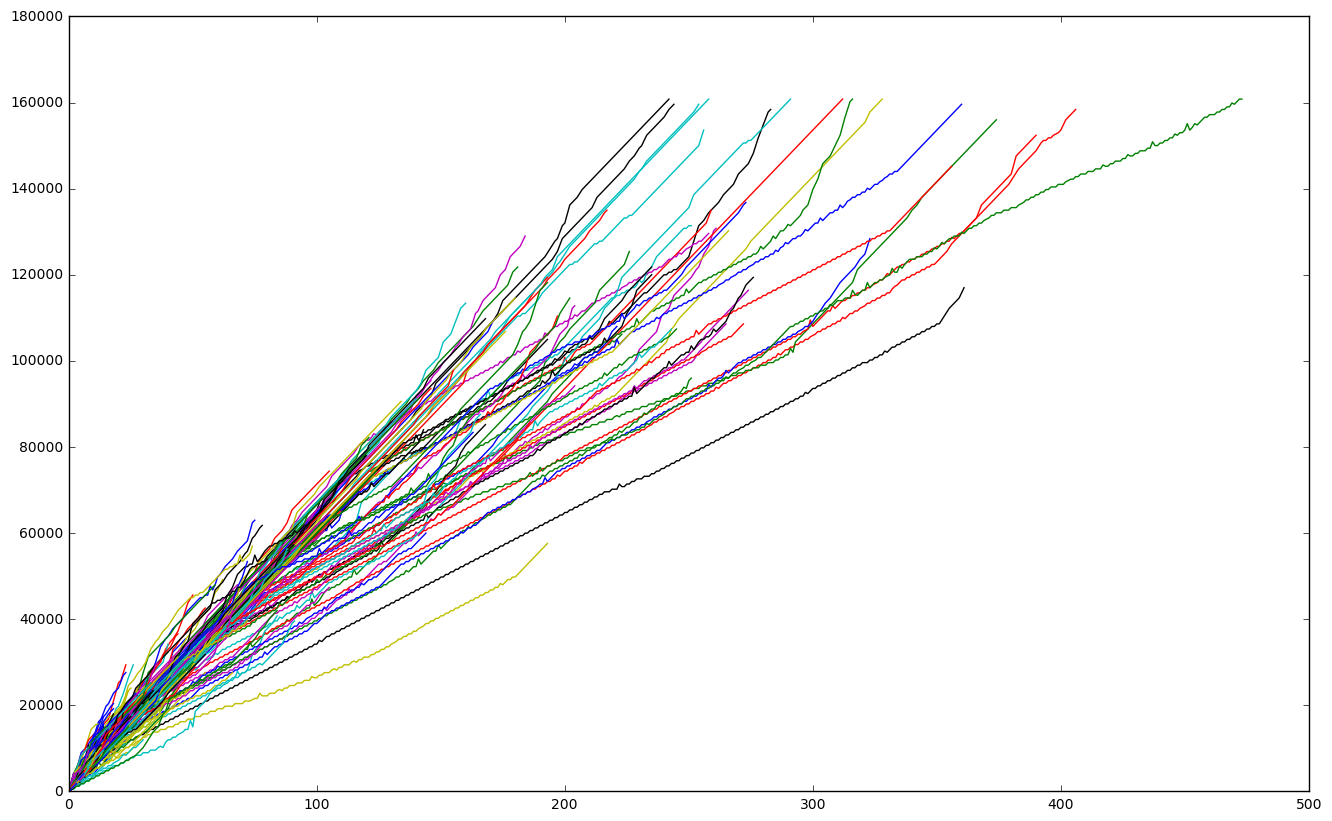

In [26]:
for track in ba.TRACK_ID.unique():
    sub = ba[ba.TRACK_ID == track]
    pt.plot(range(sub.index.size), sub.EDGE_TIME - sub.EDGE_TIME.min())
    
frm = pt.gcf()
frm.set_size_inches(16, 10)

In [27]:
tree, branch = parse_trees(ba)

In [28]:
svals = extract_values(tree, sits, ['POSITION_T', 'POSITION_X', 'POSITION_Y', 'TOTAL_INTENSITY', 'QUALITY'])

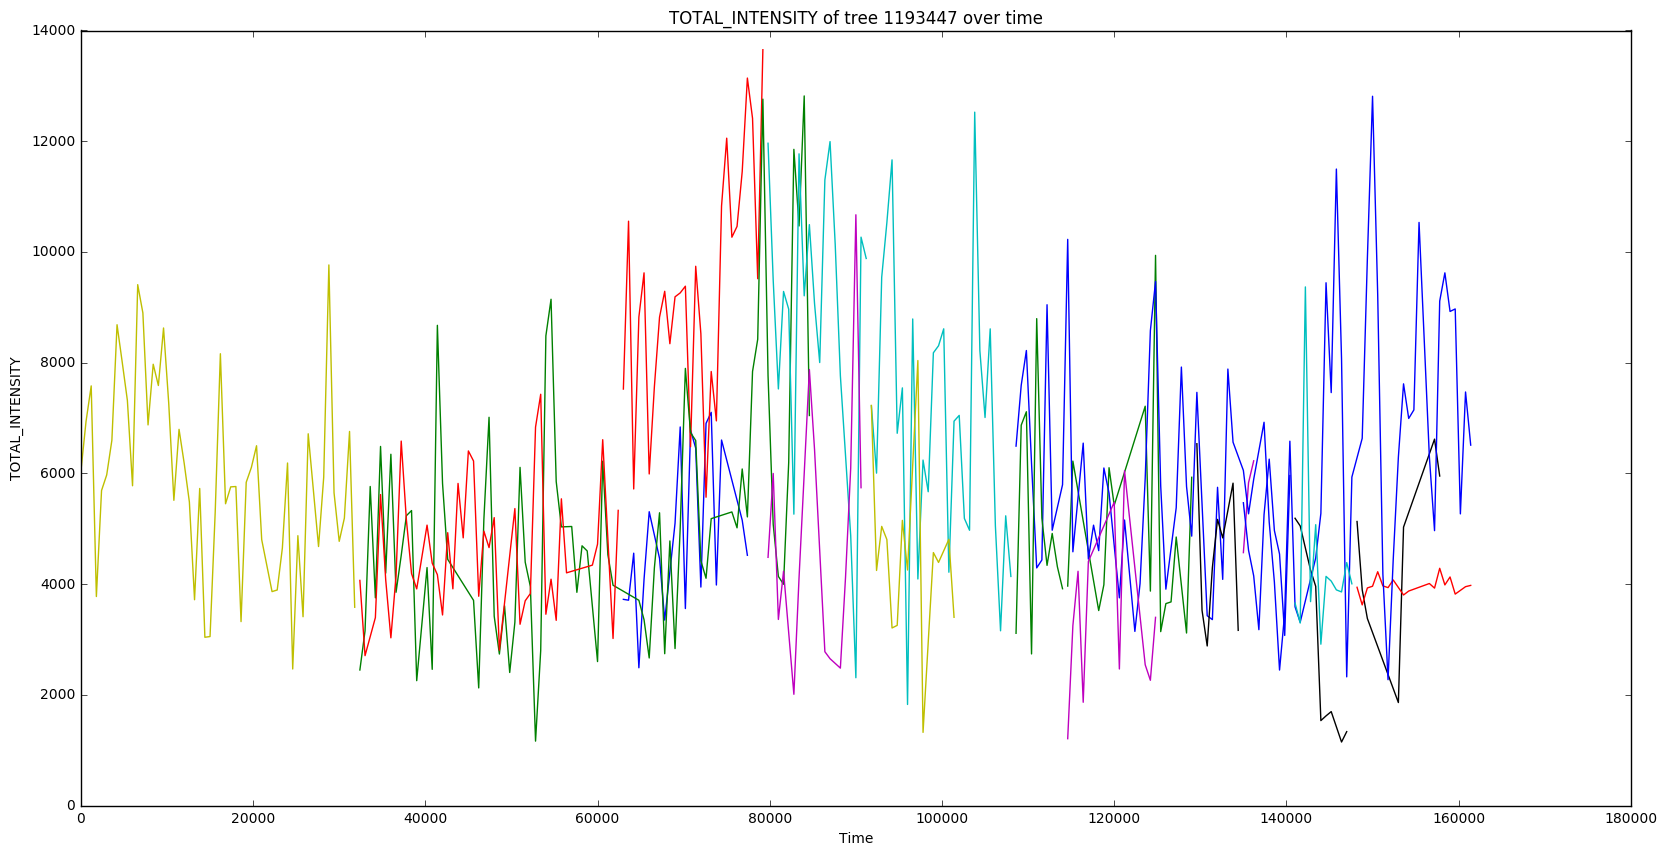

In [29]:
tree_id = list(tree.keys())[np.argmax([len(branch[x]) for x in tree.keys()])]
plot_tree_value(tree_id, "TOTAL_INTENSITY", svals)

### II. Filter Trees

In [30]:
## WARNING: trees filtering by time affect other trees

# tree_filtered, branch_filtered, svals_filtered = filter_trees_by_time(tree, branch, svals)
tree, branch, svals = filter_trees_by_time(tree, branch, svals)

### III. Slit Asignment

In [31]:
path = '../test/eli-new-unsync-bf-%d/in-focus/before' % POSITION
impath = 'bf_in-focusxy%dc1c1-mask.tif' % POSITION
imorigpath = 'bf_in-focusxy%dc1c1.tif' % POSITION
immask = '../test/eli-new-unsync-bf-%d/out-focus/merged/merged.tif' % POSITION

im = cv2.imread(os.path.join(path, impath))
imorig = cv2.imread(os.path.join(path, imorigpath))
immask = cv2.imread(immask)

gray= cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
im2, contours, hierarchy  = cv2.findContours(gray,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

In [32]:
cts, cts_size, cts_size_al = get_contour(os.path.join(path, impath))

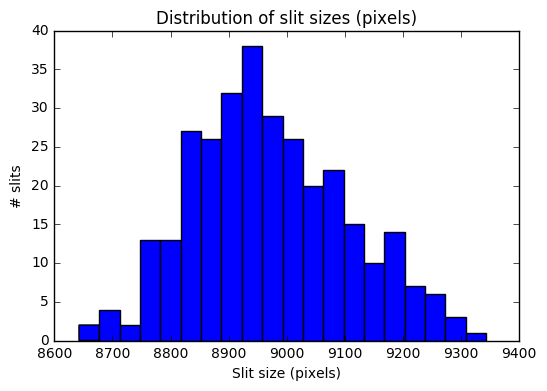

In [33]:
pt.hist(cts_size, bins=20)
pt.title("Distribution of slit sizes (pixels)")
pt.xlabel("Slit size (pixels)")
pt.ylabel("# slits")
pt.show()

In [34]:
assocs, occuppancy = assign_tree_to_contours(svals, cts)

In [35]:
print("# of trees in slit: %d" % assocs[~assocs.SLIT_ID.isnull()].index.size)
print("Ratio  of cell lines not identified to specific slit: %f" % (assocs[assocs.SLIT_ID.isnull()].index.size / assocs.index.size))
print("ratio of slit not associated with any cell lineage: %f" % (occuppancy[occuppancy == 0].size / occuppancy.size))

# of trees in slit: 75
Ratio  of cell lines not identified to specific slit: 0.218750
ratio of slit not associated with any cell lineage: 0.783871


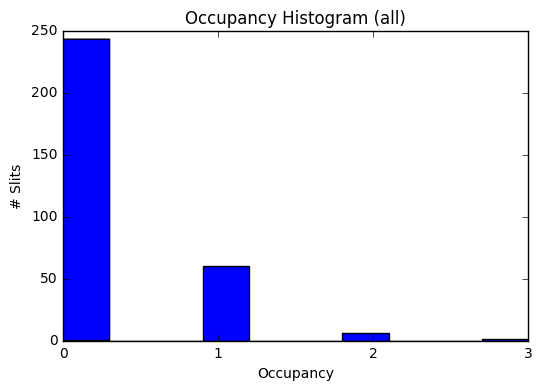

In [36]:
pt.hist(list(occuppancy))
pt.xticks(range(max(occuppancy) + 1))
pt.xlabel("Occupancy")
pt.ylabel("# Slits")
pt.title("Occupancy Histogram (all)")

# pt.gcf().set_size_inches(8, 5)

### IV. Valid Trees Analysis

In [37]:
# dev pipeline
doubly_placed_tree = get_trees_by_placement(assocs, placement=2)
print("# of doubly-placed trees: %d" % len(doubly_placed_tree))

singly_placed_tree = get_trees_by_placement(assocs, placement=1)
print("# of singly-placed trees: %d" % len(singly_placed_tree))

# of doubly-placed trees: 6
# of singly-placed trees: 60


### V. Embed Signal Information Into Data

In [38]:
# Embed Caspase

tree_unpruned = copy.deepcopy(tree)
branch_unpruned = copy.deepcopy(branch)
svals_unpruned = copy.deepcopy(svals)

for t in (singly_placed_tree + doubly_placed_tree):
    t_tree, t_branch, _, this_svals = embed_cell_death_signal(t, tree, branch, svals, caspase_tiff_path)
    tree[t] = t_tree
    branch[t] = t_branch
    svals = this_svals
    
if PROCESS_PI:
    # Embed PI

    for t in (singly_placed_tree + doubly_placed_tree):
        t_tree, t_branch, _, this_svals = embed_cell_death_signal(t, tree, branch, svals, pi_tiff_path, caspase=False)
        tree[t] = t_tree
        branch[t] = t_branch
        svals = this_svals

processing tree 1194242
  processing branch 1194242
  processing branch 1863884
  processing branch 1863885
  processing branch 1933653
  processing branch 2223209
  processing branch 2389168
  processing branch 2389199
  processing branch 2441563
  processing branch 2441532
  processing branch 2223178
  processing branch 1933631
  processing branch 2014075
  processing branch 2014098
processing tree 1193220
  processing branch 1193220
processing tree 1192469
  processing branch 1192469
processing tree 1194004
  processing branch 1194004
  processing branch 1292395
  processing branch 1340182
  processing branch 1427670
  processing branch 1427683
  processing branch 1500163
  processing branch 1657740
  processing branch 1747570
  processing branch 1747583
  processing branch 1876277
  processing branch 1876278
  processing branch 1933287
  processing branch 1933311
  processing branch 2209158
  processing branch 2209219
  processing branch 1657726
  processing branch 1500162
  proces

###  VI. Iterative filtering of valid trees

In [39]:
singly_placed_tree_divs, \
    invalid_trees_nodiv, \
    invalid_trees_morethan1div, \
    tree_one_div, \
    tree_one_div_div_times, \
    tree_divbfrtreatment, \
    tree_divbfrtreatment_div_times, \
    tree_divbfrtreatment_last_time_1, \
    tree_divbfrtreatment_last_time_2, \
    tree_deathaftertreatment, \
    tree_deathaftertreatment_div_times, \
    last_time_1, \
    last_time_2 = filter_invalid_trees(singly_placed_tree, tree, branch, svals)

# of singly-placed trees with 0 div: 26
# of singly-placed trees with 1 div: 13
# of singly-placed trees with >1 divs: 21
# trees with division time before treatment: 12
# trees with both branches' last measurement time after treatment: 7


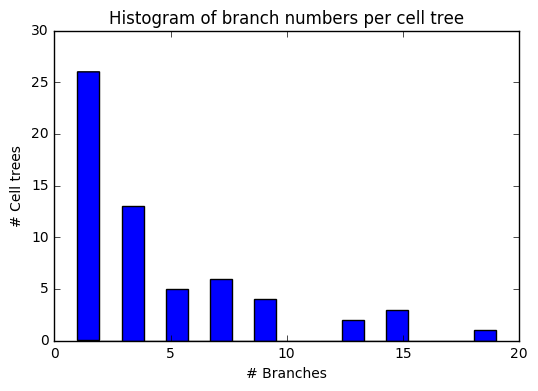

In [40]:
# plot number of divisions of valid trees

pt.hist(singly_placed_tree_divs, bins=max(singly_placed_tree_divs))
pt.title("Histogram of branch numbers per cell tree")
pt.ylabel("# Cell trees")
pt.xlabel("# Branches")

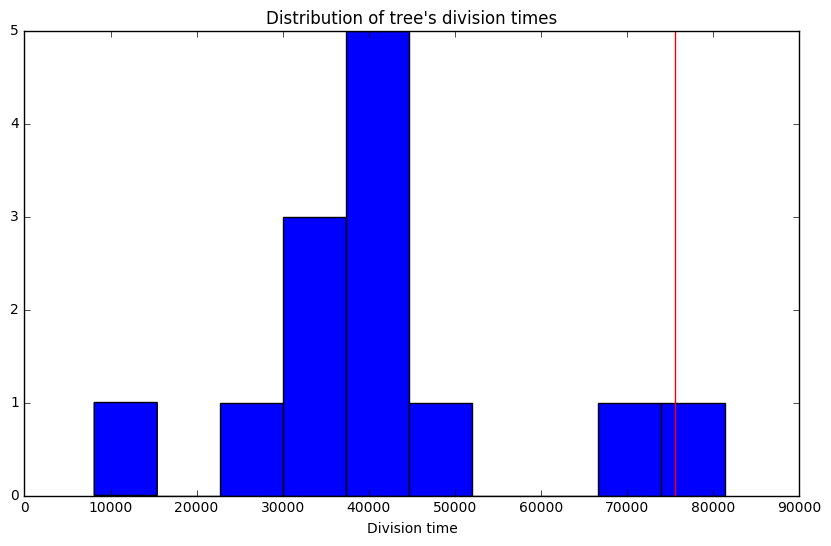

In [41]:
## CHANGED

pt.hist(tree_one_div_div_times)
pt.title("Distribution of tree's division times")
pt.xlabel("Division time")
pt.axvline(126 * TIME_UNIT_FACTOR, c='red')
pt.gcf().set_size_inches(10, 6)

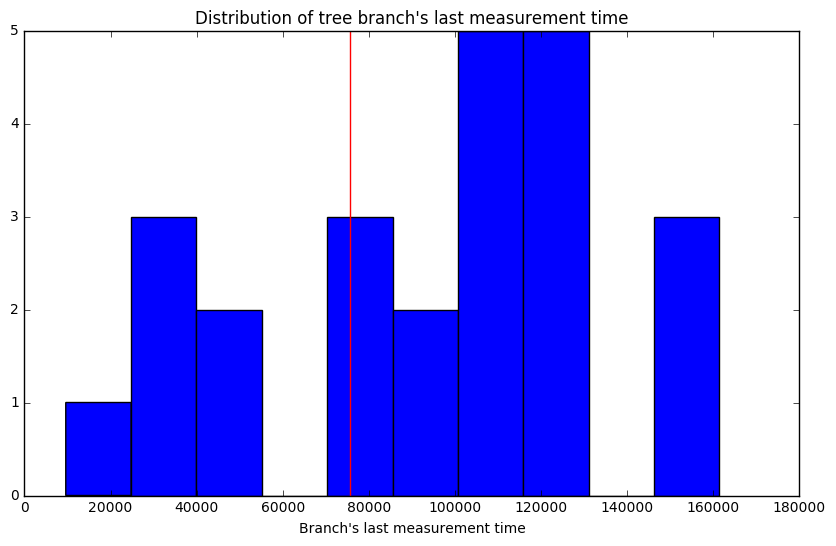

In [42]:
pt.hist(tree_divbfrtreatment_last_time_1 + tree_divbfrtreatment_last_time_2)
pt.title("Distribution of tree branch's last measurement time")
pt.xlabel("Branch's last measurement time")
pt.axvline(126 * TIME_UNIT_FACTOR, c='red')
pt.gcf().set_size_inches(10, 6)

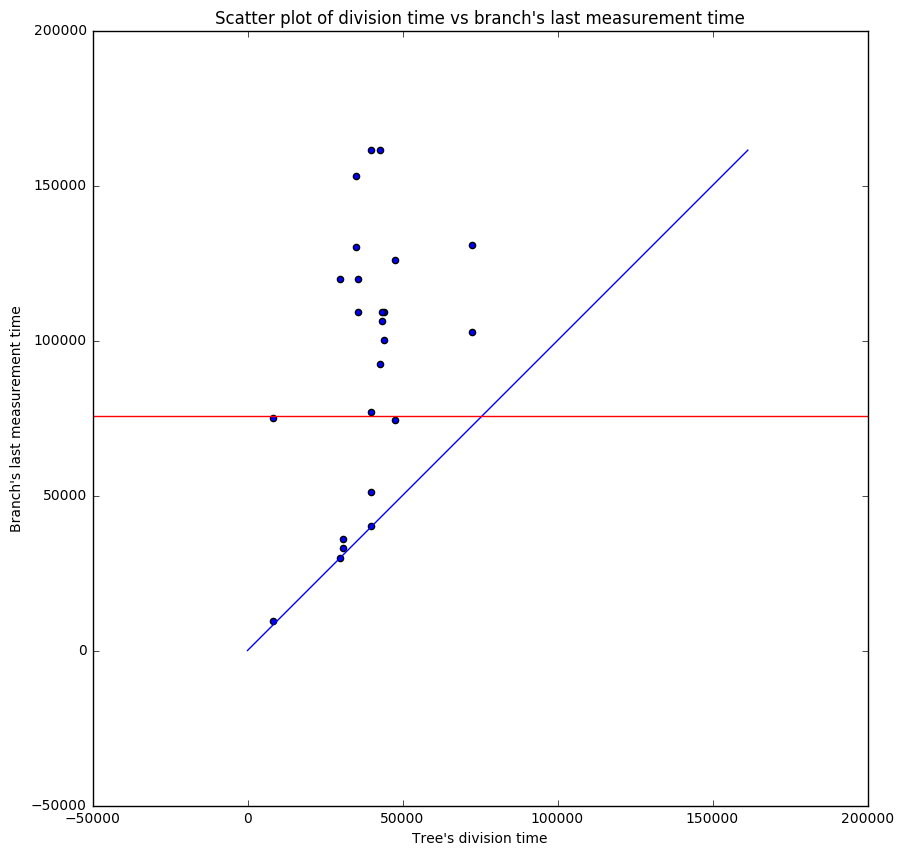

In [43]:
high = int(max(tree_divbfrtreatment_div_times + tree_divbfrtreatment_last_time_1 + tree_divbfrtreatment_last_time_2))
pt.scatter(tree_divbfrtreatment_div_times, tree_divbfrtreatment_last_time_1)
pt.scatter(tree_divbfrtreatment_div_times, tree_divbfrtreatment_last_time_2)
pt.plot(list(range(high)), list(range(high)))

pt.title("Scatter plot of division time vs branch's last measurement time")
pt.xlabel("Tree's division time")
pt.ylabel("Branch's last measurement time")
pt.axhline(126 * TIME_UNIT_FACTOR, c='red')
pt.gcf().set_size_inches(10, 10)

In [44]:
tree_deathaftertreatment

[1194040, 1194114, 1193131, 1192121, 1192934, 1193553, 1190911]

In [45]:
ttd1 = [(x - 126 * TIME_UNIT_FACTOR) for x in last_time_1]
ttd2 = [(x - 126 * TIME_UNIT_FACTOR) for x in last_time_2]

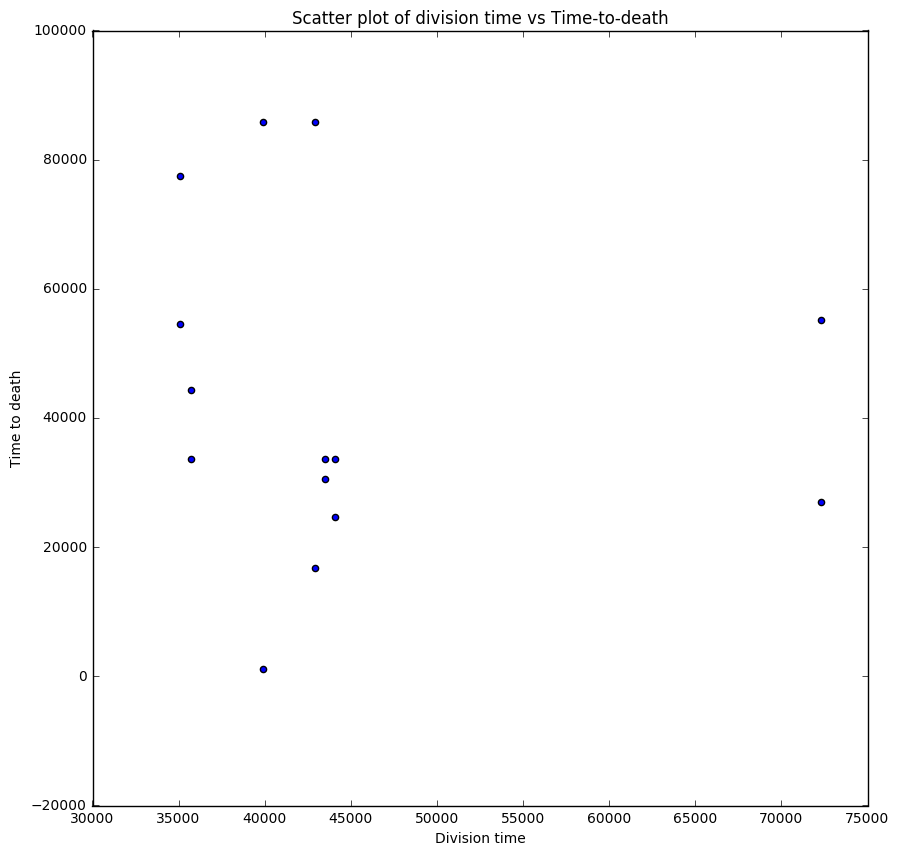

In [46]:
pt.scatter(tree_deathaftertreatment_div_times, ttd1)
pt.scatter(tree_deathaftertreatment_div_times, ttd2)
pt.title("Scatter plot of division time vs Time-to-death")
pt.xlabel("Division time")
pt.ylabel("Time to death")
pt.gcf().set_size_inches(10, 10)

### V. Export Tree Data

In [47]:
write_time_to_death_statistics(exit_dat, tree_deathaftertreatment, tree_deathaftertreatment_div_times, ttd1, ttd2)

### VI. Export TIFFs

In [48]:
## draw contours with $num cell lineages

num = 0

ctsprint = [cts[x] for x in list(np.argwhere(occuppancy == num).T[[0]][0])]

imc = imorig.copy()
cv2.drawContours(imc, ctsprint, -1, (255, 0, 0), 4)
cv2.imwrite(os.path.join(path, 'im_contours_%d.tiff' % num), imc);

imc = immask.copy()
cv2.drawContours(imc, ctsprint, -1, (255, 0, 0), 4)
cv2.imwrite(os.path.join(path, 'im_contours_%d_mask.tiff' % num), imc);

In [49]:
## draw all spots in T=0

imc = imorig.copy()
for sid in ss[ss.POSITION_T == 0]['ID']:
    x = ss[ss.ID == sid]['POSITION_X'].values[0] / PIXEL_INCH_RATIO
    y = ss[ss.ID == sid]['POSITION_Y'].values[0] / PIXEL_INCH_RATIO
    cv2.circle(imc, (int(x) + 3, int(y) + 3), 4, (255, 255, 0), -1)
cv2.imwrite(os.path.join(path, 'all_t0.tiff'), imc);

In [50]:
## draw contours with $num cell lineages

num = 1

ctsprint = [cts[x] for x in list(np.argwhere(occuppancy == num).T[[0]][0])]

imc = imorig.copy()
cv2.drawContours(imc, ctsprint, -1, (255, 0, 0), 4)
for tr in list(np.argwhere(occuppancy == num).T[[0]][0]):
    pths = assocs[assocs.SLIT_ID == tr].CELL_LINE.tolist()
    for pth in pths:
        y = svals['POSITION_Y'][pth][pth][0] / PIXEL_INCH_RATIO
        x = svals['POSITION_X'][pth][pth][0] / PIXEL_INCH_RATIO
        cv2.circle(imc, (int(x), int(y)), 4, (0, 255, 0), -1)
#         cv2.putText(imc,"track %d: coord (%d, %d)" % (pth, int(x), int(y)), 
#                     (int(x), int(y)), cv2.FONT_HERSHEY_COMPLEX, 0.8,(255,255,255),2,cv2.LINE_AA)
cv2.imwrite(os.path.join(path, 'im_contours_%d.tiff' % num), imc);

imc = immask.copy()
cv2.drawContours(imc, ctsprint, -1, (255, 0, 0), 4)
for tr in list(np.argwhere(occuppancy == num).T[[0]][0]):
    pths = assocs[assocs.SLIT_ID == tr].CELL_LINE.tolist()
    for pth in pths:
        y = svals['POSITION_Y'][pth][pth][0] / PIXEL_INCH_RATIO
        x = svals['POSITION_X'][pth][pth][0] / PIXEL_INCH_RATIO
        cv2.circle(imc, (int(x), int(y)), 4, (0, 255, 0), -1)
#         cv2.putText(imc,"track %d: coord (%d, %d)" % (pth, int(x), int(y)), 
#                     (int(x), int(y)), cv2.FONT_HERSHEY_COMPLEX, 0.8,(255,255,255),2,cv2.LINE_AA)
cv2.imwrite(os.path.join(path, 'im_contours_%d_mask.tiff' % num), imc);

In [51]:
## draw contours with $num cell lineages

num = 2

ctsprint = [cts[x] for x in list(np.argwhere(occuppancy == num).T[[0]][0])]

imc = imorig.copy()
cv2.drawContours(imc, ctsprint, -1, (255, 0, 0), 4)
for tr in list(np.argwhere(occuppancy == num).T[[0]][0]):
    pths = assocs[assocs.SLIT_ID == tr].CELL_LINE.tolist()
    for pth in pths:
        y = svals['POSITION_Y'][pth][pth][0] / PIXEL_INCH_RATIO
        x = svals['POSITION_X'][pth][pth][0] / PIXEL_INCH_RATIO
        cv2.circle(imc, (int(x), int(y)), 4, (0, 255, 0), -1)
#         cv2.putText(imc,"track %d: coord (%d, %d)" % (pth, int(x), int(y)), 
#                     (int(x), int(y)), cv2.FONT_HERSHEY_COMPLEX, 0.8,(255,255,255),2,cv2.LINE_AA)
cv2.imwrite(os.path.join(path, 'im_contours_%d.tiff' % num), imc);

imc = immask.copy()
cv2.drawContours(imc, ctsprint, -1, (255, 0, 0), 4)
for tr in list(np.argwhere(occuppancy == num).T[[0]][0]):
    pths = assocs[assocs.SLIT_ID == tr].CELL_LINE.tolist()
    for pth in pths:
        y = svals['POSITION_Y'][pth][pth][0] / PIXEL_INCH_RATIO
        x = svals['POSITION_X'][pth][pth][0] / PIXEL_INCH_RATIO
        cv2.circle(imc, (int(x), int(y)), 4, (0, 255, 0), -1)
#         cv2.putText(imc,"track %d: coord (%d, %d)" % (pth, int(x), int(y)), 
#                     (int(x), int(y)), cv2.FONT_HERSHEY_COMPLEX, 0.8,(255,255,255),2,cv2.LINE_AA)
cv2.imwrite(os.path.join(path, 'im_contours_%d_mask.tiff' % num), imc);

In [52]:
## draw contours with $num cell lineages

num = 3

ctsprint = [cts[x] for x in list(np.argwhere(occuppancy == num).T[[0]][0])]

imc = imorig.copy()
cv2.drawContours(imc, ctsprint, -1, (255, 0, 0), 4)
for tr in list(np.argwhere(occuppancy == num).T[[0]][0]):
    pths = assocs[assocs.SLIT_ID == tr].CELL_LINE.tolist()
    for pth in pths:
        y = svals['POSITION_Y'][pth][pth][0] / PIXEL_INCH_RATIO
        x = svals['POSITION_X'][pth][pth][0] / PIXEL_INCH_RATIO
        cv2.circle(imc, (int(x), int(y)), 4, (0, 255, 0), -1)
#         cv2.putText(imc,"track %d: coord (%d, %d)" % (pth, int(x), int(y)), 
#                     (int(x), int(y)), cv2.FONT_HERSHEY_COMPLEX, 0.8,(255,255,255),2,cv2.LINE_AA)
cv2.imwrite(os.path.join(path, 'im_contours_%d.tiff' % num), imc);

imc = immask.copy()
cv2.drawContours(imc, ctsprint, -1, (255, 0, 0), 4)
for tr in list(np.argwhere(occuppancy == num).T[[0]][0]):
    pths = assocs[assocs.SLIT_ID == tr].CELL_LINE.tolist()
    for pth in pths:
        y = svals['POSITION_Y'][pth][pth][0] / PIXEL_INCH_RATIO
        x = svals['POSITION_X'][pth][pth][0] / PIXEL_INCH_RATIO
        cv2.circle(imc, (int(x), int(y)), 4, (0, 255, 0), -1)
#         cv2.putText(imc,"track %d: coord (%d, %d)" % (pth, int(x), int(y)), 
#                     (int(x), int(y)), cv2.FONT_HERSHEY_COMPLEX, 0.8,(255,255,255),2,cv2.LINE_AA)
cv2.imwrite(os.path.join(path, 'im_contours_%d_mask.tiff' % num), imc);

### VII. Sanity Check of Recognized Pipline

In [53]:
"""
NOTE for sanity check always use the unmodified data, i.e.:
- tree_unpruned
- branch_unpruned
- svals_unpruned
"""

## export video of valid trees

for t in tree_deathaftertreatment:
    export_snapshot([t], 
                    tree_assoc=assocs, 
                    slit_contours=cts, 
                    tree=tree_unpruned, 
                    branch=branch_unpruned, 
                    tree_values=svals_unpruned, 
                    tiff_path='../test/eli-new-unsync-bf-%d/out-focus/merged/merged.tif' % POSITION, 
                    out_path='../test/eli-new-unsync-bf-%d/out-focus/merged/single_analysis/valid/' % POSITION)

Exporting snapshot for trees: [1194040]
Exporting snapshot for tree 1194040...
branch configuration for tree 1194040:
{1194040: (1563520, 1563482)}
parsed queue for tree 1194040: [1194040, 1563520, 1563482]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/valid/
#Trees snapshot exported
Exporting snapshot for trees: [1194114]
Exporting snapshot for tree 1194114...
branch configuration for tree 1194114:
{1194114: (1586902, 1586874)}
parsed queue for tree 1194114: [1194114, 1586902, 1586874]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/valid/
#Trees snapshot exported
Exporting snapshot for trees: [1193131]
Exporting snapshot for tree 1193131...
branch configuration for tree 1193131:
{1193131: (1514867, 1514799)}
parsed queue for tree 1193131: [1193131, 1514867, 1514799]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/valid/
#Trees snapshot exported
Exporting snapshot for trees

In [54]:
## export video of invalid trees

for t in doubly_placed_tree:
    slit_id = assocs[assocs.CELL_LINE == t]['SLIT_ID'].values[0]
    export_snapshot_slit(slit_id,
                         tree_assoc=assocs, 
                         slit_contours=cts, 
                         tree=tree_unpruned,
                         branch=branch_unpruned, 
                         tree_values=svals_unpruned, 
                         tiff_path='../test/eli-new-unsync-bf-%d/out-focus/merged/merged.tif' % POSITION, 
                         out_path='../test/eli-new-unsync-bf-%d/out-focus/merged/single_analysis/invalid/doublyplaced/' % POSITION)

Exporting snapshot for slit 63
Exporting snapshot for trees: [1194517, 1194518]
Exporting snapshot for tree 1194517...
branch configuration for tree 1194517:
{}
parsed queue for tree 1194517: [1194517]
Exporting snapshot for tree 1194518...
branch configuration for tree 1194518:
{1194518: (1616672, 1616709)}
parsed queue for tree 1194518: [1194518, 1616672, 1616709]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/invalid/doublyplaced/
#Trees snapshot exported
Exporting snapshot for slit 28
Exporting snapshot for trees: [1195067, 1195084]
Exporting snapshot for tree 1195067...
branch configuration for tree 1195067:
{}
parsed queue for tree 1195067: [1195067]
Exporting snapshot for tree 1195084...
branch configuration for tree 1195084:
{1688724: (2843087, 2843109), 1195084: (1428645, 1428679), 1428645: (1688724, 1688763)}
parsed queue for tree 1195084: [1195084, 1428645, 1688724, 2843087, 2843109, 1688763, 1428679]
writting video to dir: ../test/eli-n

In [55]:
## export video of invalid trees

for t in invalid_trees_nodiv:
    export_snapshot([t],
                    tree_assoc=assocs, 
                    slit_contours=cts, 
                    tree=tree_unpruned, 
                    branch=branch_unpruned, 
                    tree_values=svals_unpruned, 
                    tiff_path='../test/eli-new-unsync-bf-%d/out-focus/merged/merged.tif' % POSITION, 
                    out_path='../test/eli-new-unsync-bf-%d/out-focus/merged/single_analysis/invalid/nodiv/' % POSITION)

Exporting snapshot for trees: [1193220]
Exporting snapshot for tree 1193220...
branch configuration for tree 1193220:
{}
parsed queue for tree 1193220: [1193220]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/invalid/nodiv/
#Trees snapshot exported
Exporting snapshot for trees: [1192469]
Exporting snapshot for tree 1192469...
branch configuration for tree 1192469:
{}
parsed queue for tree 1192469: [1192469]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/invalid/nodiv/
#Trees snapshot exported
Exporting snapshot for trees: [1194790]
Exporting snapshot for tree 1194790...
branch configuration for tree 1194790:
{}
parsed queue for tree 1194790: [1194790]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/invalid/nodiv/
#Trees snapshot exported
Exporting snapshot for trees: [1191725]
Exporting snapshot for tree 1191725...
branch configuration for tree 1191725:
{}
parsed queue for t

In [56]:
## export video of invalid trees

for t in invalid_trees_morethan1div:
    export_snapshot([t],
                    tree_assoc=assocs, 
                    slit_contours=cts, 
                    tree=tree_unpruned, 
                    branch=branch_unpruned, 
                    tree_values=svals_unpruned, 
                    tiff_path='../test/eli-new-unsync-bf-%d/out-focus/merged/merged.tif' % POSITION, 
                    out_path='../test/eli-new-unsync-bf-%d/out-focus/merged/single_analysis/invalid/morethan1div/' % POSITION)

Exporting snapshot for trees: [1194242]
Exporting snapshot for tree 1194242...
branch configuration for tree 1194242:
{1194242: (1863884, 1863885), 1933653: (2223209, 2223178), 2223209: (2389168, 2389199), 2389199: (2441563, 2441532), 1863885: (1933653, 1933631), 1933631: (2014075, 2014098)}
parsed queue for tree 1194242: [1194242, 1863884, 1863885, 1933653, 2223209, 2389168, 2389199, 2441563, 2441532, 2223178, 1933631, 2014075, 2014098]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/invalid/morethan1div/
#Trees snapshot exported
Exporting snapshot for trees: [1194004]
Exporting snapshot for tree 1194004...
branch configuration for tree 1194004:
{1500163: (1657740, 1657726), 1194004: (1292395, 1292352), 1876278: (1933287, 1933311), 1340182: (1427670, 1427683), 1427683: (1500163, 1500162), 1933311: (2209158, 2209219), 1292395: (1340182, 1340129), 1657740: (1747570, 1747583), 1747583: (1876277, 1876278)}
parsed queue for tree 1194004: [1194004, 12923

In [57]:
## export video of invalid trees

invalid_trees_divaftertreatment = set(tree_one_div) - set(tree_divbfrtreatment)

for t in invalid_trees_divaftertreatment:
    export_snapshot([t],
                    tree_assoc=assocs, 
                    slit_contours=cts, 
                    tree=tree_unpruned, 
                    branch=branch_unpruned, 
                    tree_values=svals_unpruned, 
                    tiff_path='../test/eli-new-unsync-bf-%d/out-focus/merged/merged.tif' % POSITION, 
                    out_path='../test/eli-new-unsync-bf-%d/out-focus/merged/single_analysis/invalid/divaftertreatment/' % POSITION)

Exporting snapshot for trees: [1193193]
Exporting snapshot for tree 1193193...
branch configuration for tree 1193193:
{1193193: (1980085, 1980047)}
parsed queue for tree 1193193: [1193193, 1980085, 1980047]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/invalid/divaftertreatment/
#Trees snapshot exported


In [58]:
## export video of invalid trees

invalid_trees_deathbeforetreatment = list(set(tree_divbfrtreatment) - set(tree_deathaftertreatment))

for t in invalid_trees_deathbeforetreatment:
    export_snapshot([t], 
                    tree_assoc=assocs, 
                    slit_contours=cts, 
                    tree=tree_unpruned,
                    branch=branch_unpruned,
                    tree_values=svals_unpruned, 
                    tiff_path='../test/eli-new-unsync-bf-%d/out-focus/merged/merged.tif' % POSITION, 
                    out_path='../test/eli-new-unsync-bf-%d/out-focus/merged/single_analysis/invalid/deathbeforetreatmen/' % POSITION)

Exporting snapshot for trees: [1192696]
Exporting snapshot for tree 1192696...
branch configuration for tree 1192696:
{1192696: (1470863, 1470918)}
parsed queue for tree 1192696: [1192696, 1470863, 1470918]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/invalid/deathbeforetreatmen/
#Trees snapshot exported
Exporting snapshot for trees: [1194217]
Exporting snapshot for tree 1194217...
branch configuration for tree 1194217:
{1194217: (1563736, 1563715)}
parsed queue for tree 1194217: [1194217, 1563736, 1563715]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/invalid/deathbeforetreatmen/
#Trees snapshot exported
Exporting snapshot for trees: [1189969]
Exporting snapshot for tree 1189969...
branch configuration for tree 1189969:
{1189969: (1635869, 1635893)}
parsed queue for tree 1189969: [1189969, 1635869, 1635893]
writting video to dir: ../test/eli-new-unsync-bf-40/out-focus/merged/single_analysis/invalid/deathbef

### VIII. Death Signal Embedding and Analysis

In [59]:
"""
Experiment conf:
out-focus = 21 hrs (126 slides a 10 mins) + 24 hrs (144 slides a 10 mins)
caspacin = 24 hrs (48 slides a 30 mins)
first slide of caspacin refers to (126 + 1) * 600 = 76200
pi = 45 hrs (90 slides a 30 mins)
first slide of pi refers to 0

cell death cut-off value: 1000
"""

'\nExperiment conf:\nout-focus = 21 hrs (126 slides a 10 mins) + 24 hrs (144 slides a 10 mins)\ncaspacin = 24 hrs (48 slides a 30 mins)\nfirst slide of caspacin refers to (126 + 1) * 600 = 76200\npi = 45 hrs (90 slides a 30 mins)\nfirst slide of pi refers to 0\n\ncell death cut-off value: 1000\n'

In [60]:
csp_sub_vid = get_video(caspase_tiff_sub_path)
csp_sub_brgt_norm = [cv2.sumElems(x)[0] / (x.shape[0] * x.shape[1]) for x in csp_sub_vid]

csp_vid = get_video(caspase_tiff_path)
csp_brgt_norm = [cv2.sumElems(x)[0] / (x.shape[0] * x.shape[1]) for x in csp_vid]

In [61]:
cv2.sumElems(csp_vid[0])[0] / (csp_vid[0].shape[0] * csp_vid[0].shape[1])

3947.18884883408

In [70]:
## CAREFUL ABOUT ENCODING!!

np.array([np.max(x) for x in csp_sub_vid]) - np.array([np.max(x) for x in csp_vid])

array([59068, 59480, 60235, 60426, 55563, 54960, 54890, 54890, 54890,
       54890, 60426, 60426, 61029, 61557, 60750, 60186, 61040, 61064,
       61115, 61113, 61517, 61196, 61313, 61409, 55022, 54846, 54846,
       54638, 54638, 55031, 54822, 54774, 55125, 55125, 55034, 57270,
       60569, 59215, 58536, 61120, 59591, 59653, 60072, 59841, 60115,
       60378, 60858, 61109], dtype=uint16)

In [88]:
## CAREFUL ABOUT ENCODING!!

np.array([np.max(x) for x in csp_sub_vid])

array([  866,  1235,  1825,  2035,  3851, 19360, 23156, 22021, 18996,
       12144, 13743, 19301, 18195, 11717,  6925,  6312, 11021, 12006,
       11596, 14218, 11647, 12133, 23184, 15699,  8764,  9121, 10210,
       10045, 10960, 10920, 11256, 11709, 12383, 12131, 11587, 11253,
       13117,  9956,  9320, 14163, 23979, 23746, 27638, 21229, 19948,
       22429, 16110, 26006], dtype=uint16)

In [83]:
## CAREFUL ABOUT ENCODING!!

np.array([np.max(x) for x in csp_sub_vid])

array([  866,  1235,  1825,  2035,  3851, 19360, 23156, 22021, 18996,
       12144, 13743, 19301, 18195, 11717,  6925,  6312, 11021, 12006,
       11596, 14218, 11647, 12133, 23184, 15699,  8764,  9121, 10210,
       10045, 10960, 10920, 11256, 11709, 12383, 12131, 11587, 11253,
       13117,  9956,  9320, 14163, 23979, 23746, 27638, 21229, 19948,
       22429, 16110, 26006], dtype=uint16)

In [79]:
## CAREFUL ABOUT ENCODING!!

np.array([np.max(x) for x in csp_vid])

array([ 7334,  7291,  7126,  7145, 13824, 29936, 33802, 32667, 29642,
       22790, 18853, 24411, 22702, 15696, 11711, 11662, 15517, 16478,
       16017, 18641, 15666, 16473, 27407, 19826, 19278, 19811, 20900,
       20943, 21858, 21425, 21970, 22471, 22794, 22542, 22089, 19519,
       18084, 16277, 16320, 18579, 29924, 29629, 33102, 26924, 25369,
       27587, 20788, 30433], dtype=uint16)

In [97]:
## CAREFUL ABOUT ENCODING!!

np.array([np.max(x) for x in csp_sub_vid], dtype=np.int64) - np.array([np.max(x) for x in csp_vid], dtype=np.int64)

array([ -6468,  -6056,  -5301,  -5110,  -9973, -10576, -10646, -10646,
       -10646, -10646,  -5110,  -5110,  -4507,  -3979,  -4786,  -5350,
        -4496,  -4472,  -4421,  -4423,  -4019,  -4340,  -4223,  -4127,
       -10514, -10690, -10690, -10898, -10898, -10505, -10714, -10762,
       -10411, -10411, -10502,  -8266,  -4967,  -6321,  -7000,  -4416,
        -5945,  -5883,  -5464,  -5695,  -5421,  -5158,  -4678,  -4427], dtype=int64)

In [154]:
np.percentile(range(100), 60)

59.399999999999999

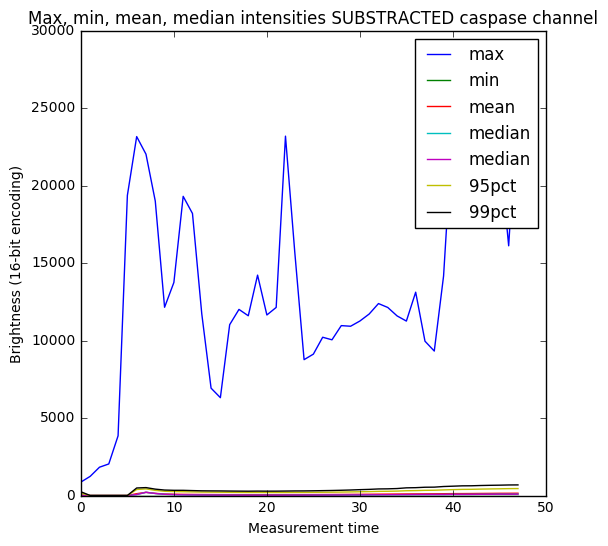

In [207]:
idx = range(len([np.max(x) for x in csp_sub_vid]))
pt.plot(idx, [np.max(x) for x in csp_sub_vid], label="max")
pt.plot(idx, [np.min(x) for x in csp_sub_vid], label="min")
pt.plot(idx, [np.mean(x) for x in csp_sub_vid], label="mean")
pt.plot(idx, [np.median(x) for x in csp_sub_vid], label="median")
pt.plot(idx, [np.median(x) for x in csp_sub_vid], label="median")
pt.plot(idx, [np.percentile(x, 95) for x in csp_sub_vid], label="95pct")
pt.plot(idx, [np.percentile(x, 99) for x in csp_sub_vid], label="99pct")

pt.legend()
pt.xlabel("Measurement time")
pt.ylabel("Brightness (16-bit encoding)")
pt.title("Max, min, mean, median intensities SUBSTRACTED caspase channel")
pt.gcf().set_size_inches(6, 6)

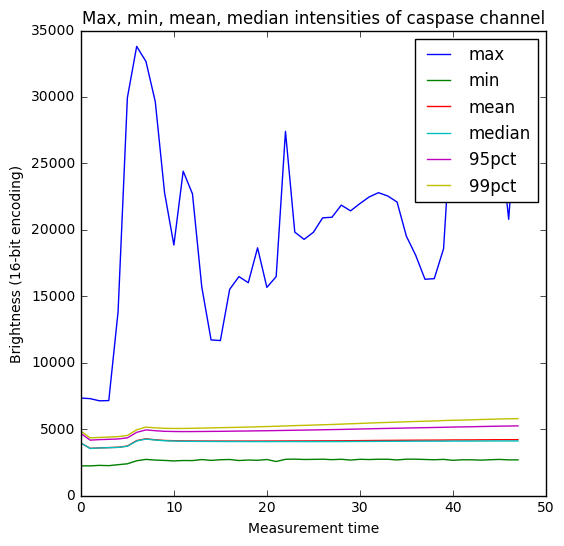

In [208]:
idx = range(len([np.max(x) for x in csp_vid]))
pt.plot(idx, [np.max(x) for x in csp_vid], label="max")
pt.plot(idx, [np.min(x) for x in csp_vid], label="min")
pt.plot(idx, [np.mean(x) for x in csp_vid], label="mean")
pt.plot(idx, [np.median(x) for x in csp_vid], label="median")
pt.plot(idx, [np.percentile(x, 95) for x in csp_vid], label="95pct")
pt.plot(idx, [np.percentile(x, 99) for x in csp_vid], label="99pct")

pt.legend()
pt.title("Max, min, mean, median intensities of caspase channel")
pt.xlabel("Measurement time")
pt.ylabel("Brightness (16-bit encoding)")
pt.gcf().set_size_inches(6, 6)

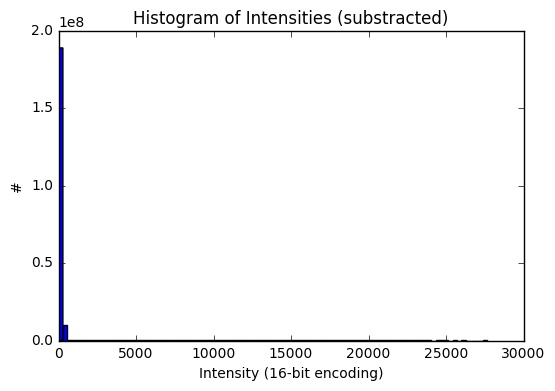

In [213]:
vals = reduce(lambda x, y: np.concatenate((x.flatten(), y.flatten())),  csp_sub_vid)
pt.hist(vals, bins=100)
pt.title("Histogram of Intensities (substracted)")
pt.xlabel("Intensity (16-bit encoding)")
pt.ylabel("#")
pt.show()
vals = []

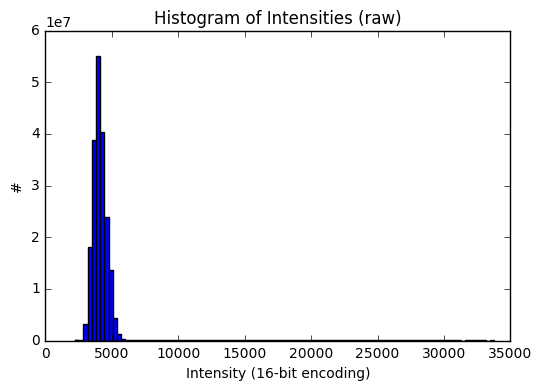

In [214]:
vals = reduce(lambda x, y: np.concatenate((x.flatten(), y.flatten())),  csp_vid)
pt.hist(vals, bins=100)
pt.title("Histogram of Intensities (raw)")
pt.xlabel("Intensity (16-bit encoding)")
pt.ylabel("#")
pt.show()
vals = []

In [108]:
if PROCESS_PI:
    for tr in tree_deathaftertreatment:

        t_brightness, _ = extract_brightness(tr, tree_unpruned, svals_unpruned, pi_tiff_path, caspase=False)
        t_time = svals_unpruned['POSITION_T'][tr]

        for br in t_brightness:
            brightness = np.array(t_brightness[br])
            time = np.array(t_time[br])
            time = time[~np.isnan(brightness)]
            brightness= brightness[~np.isnan(brightness)]
            pt.plot(time, brightness, label="%d-%d" % (tr, br))
        
    pt.legend(loc='best')
    pt.title("Progression of PI brightness measurement over time (pre-prunning)")
    pt.ylabel("Sum of cell's pixels' brightness (8-bit encoding)")
    pt.xlabel("Time (s)")
#     pt.axhline(3500, c='r', linestyle='--')

    fr = pt.gcf()
    fr.set_size_inches(10, 10)

    pt.savefig(os.path.join(out_path_pics, "%d_pi.pdf" % POSITION))

In [109]:
if PROCESS_PI:
    for tr in tree_deathaftertreatment:

        t_brightness, _ = extract_brightness(tr, tree, svals, pi_tiff_path, caspase=False)
        t_time = svals['POSITION_T'][tr]

        for br in t_brightness:
            brightness = np.array(t_brightness[br])
            time = np.array(t_time[br])
            time = time[~np.isnan(brightness)]
            brightness= brightness[~np.isnan(brightness)]
            pt.plot(time, brightness, label="%d-%d" % (tr, br))
        
    pt.legend(loc='best')
    pt.title("Progression of PI brightness measurement over time (pre-prunning)")
    pt.ylabel("Sum of cell's pixels' brightness (8-bit encoding)")
    pt.xlabel("Time (s)")
#     pt.axhline(3500, c='r', linestyle='--')

    fr = pt.gcf()
    fr.set_size_inches(10, 10)

    pt.savefig(os.path.join(out_path_pics, "%d_pi.pdf" % POSITION))

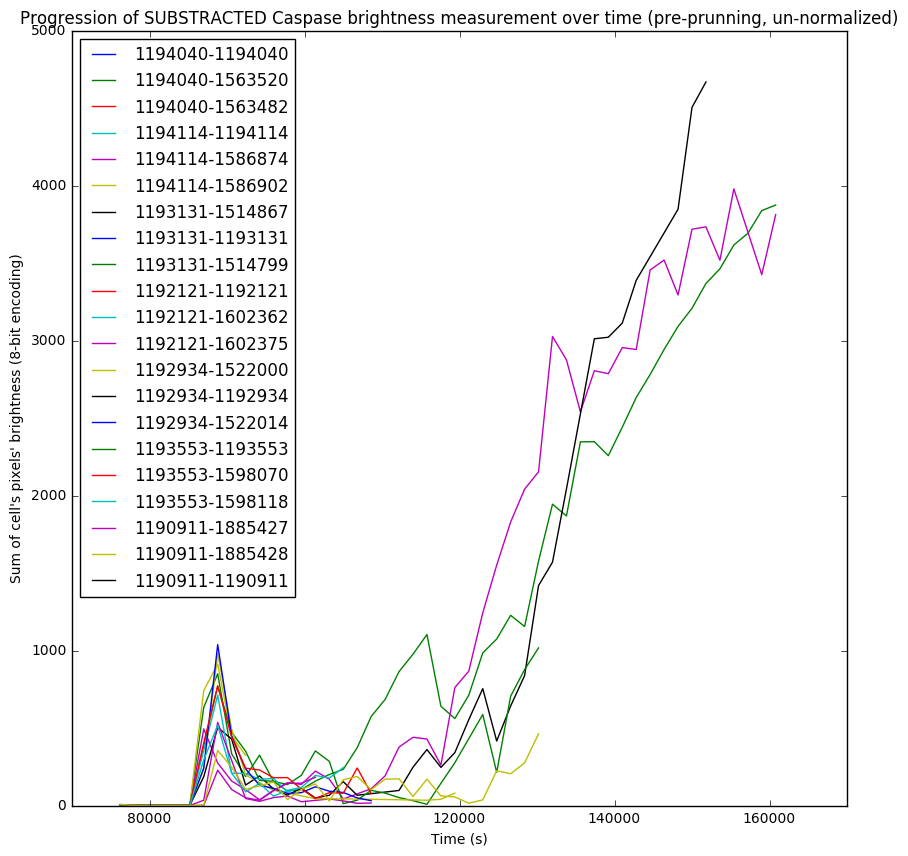

In [168]:
for tr in tree_deathaftertreatment:

    t_brightness, _ = extract_brightness(tr, tree_unpruned, svals_unpruned, caspase_tiff_sub_path, normalize=False)
    t_time = svals_unpruned['POSITION_T'][tr]

    for br in t_brightness:
        brightness = np.array(t_brightness[br])
        time = np.array(t_time[br])
        time = time[~np.isnan(brightness)]
        brightness= brightness[~np.isnan(brightness)]
        pt.plot(time, brightness, label="%d-%d" % (tr, br))
        
pt.legend(loc='best')
pt.title("Progression of SUBSTRACTED Caspase brightness measurement over time (pre-prunning, un-normalized)")
pt.ylabel("Sum of cell's pixels' brightness (8-bit encoding)")
pt.xlabel("Time (s)")
# pt.axhline(3500, c='r', linestyle='--')

fr = pt.gcf()
fr.set_size_inches(10, 10)

pt.savefig(os.path.join(out_path_pics, "%d_caspase.pdf" % POSITION))

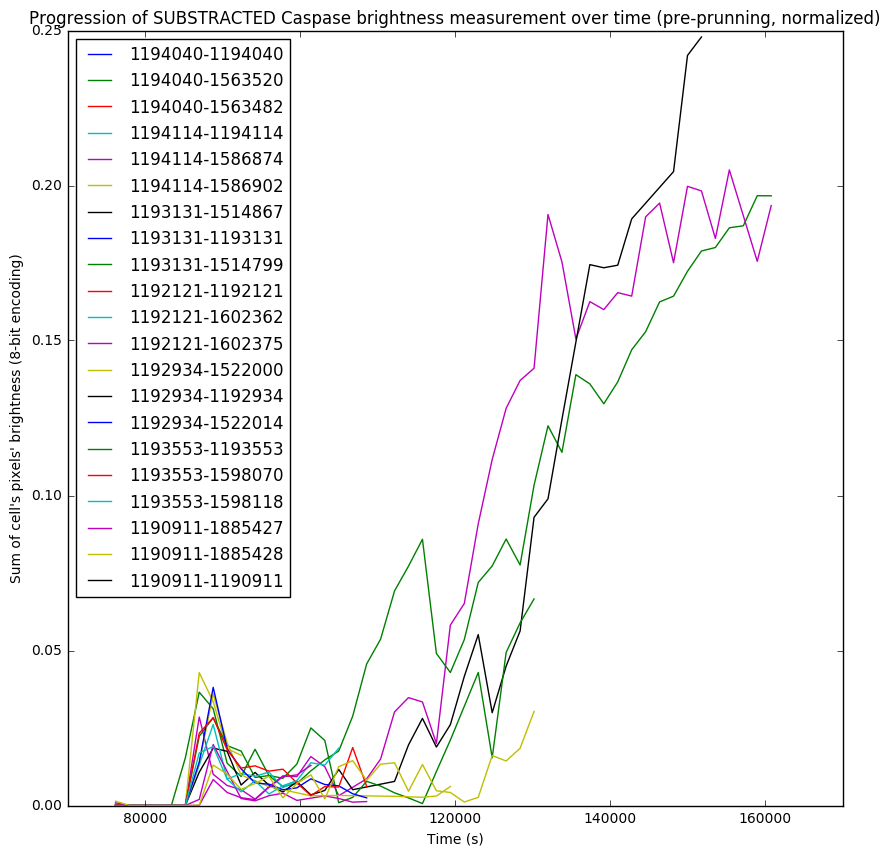

In [169]:
for tr in tree_deathaftertreatment:

    t_brightness, _ = extract_brightness(tr, tree_unpruned, svals_unpruned, caspase_tiff_sub_path, normalize=True)
    t_time = svals_unpruned['POSITION_T'][tr]

    for br in t_brightness:
        brightness = np.array(t_brightness[br])
        time = np.array(t_time[br])
        time = time[~np.isnan(brightness)]
        brightness= brightness[~np.isnan(brightness)]
        pt.plot(time, brightness, label="%d-%d" % (tr, br))
        
pt.legend(loc='best')
pt.title("Progression of SUBSTRACTED Caspase brightness measurement over time (pre-prunning, normalized)")
pt.ylabel("Sum of cell's pixels' brightness (8-bit encoding)")
pt.xlabel("Time (s)")
# pt.axhline(3500, c='r', linestyle='--')

fr = pt.gcf()
fr.set_size_inches(10, 10)

pt.savefig(os.path.join(out_path_pics, "%d_caspase.pdf" % POSITION))

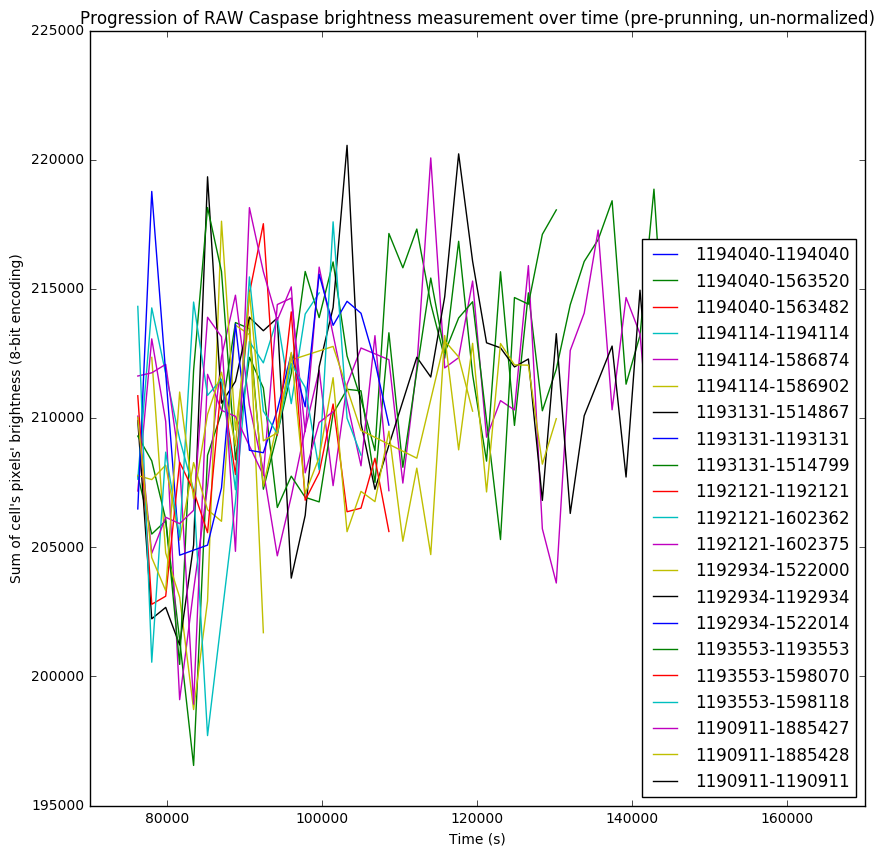

In [170]:
for tr in tree_deathaftertreatment:

    t_brightness, _ = extract_brightness(tr, tree_unpruned, svals_unpruned, caspase_tiff_path, normalize=False)
    t_time = svals_unpruned['POSITION_T'][tr]

    for br in t_brightness:
        brightness = np.array(t_brightness[br])
        time = np.array(t_time[br])
        time = time[~np.isnan(brightness)]
        brightness= brightness[~np.isnan(brightness)]
        pt.plot(time, brightness, label="%d-%d" % (tr, br))
        
pt.legend(loc='best')
pt.title("Progression of RAW Caspase brightness measurement over time (pre-prunning, un-normalized)")
pt.ylabel("Sum of cell's pixels' brightness (8-bit encoding)")
pt.xlabel("Time (s)")
# pt.axhline(3500, c='r', linestyle='--')

fr = pt.gcf()
fr.set_size_inches(10, 10)

pt.savefig(os.path.join(out_path_pics, "%d_caspase.pdf" % POSITION))

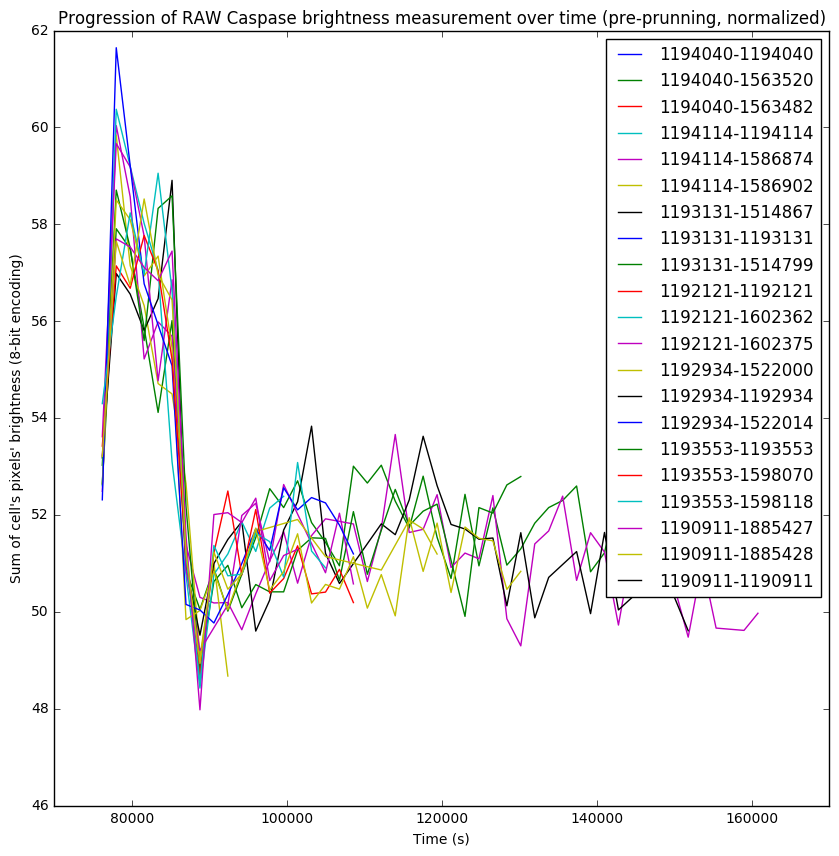

In [171]:
for tr in tree_deathaftertreatment:

    t_brightness, _ = extract_brightness(tr, tree_unpruned, svals_unpruned, caspase_tiff_path, normalize=True)
    t_time = svals_unpruned['POSITION_T'][tr]

    for br in t_brightness:
        brightness = np.array(t_brightness[br])
        time = np.array(t_time[br])
        time = time[~np.isnan(brightness)]
        brightness= brightness[~np.isnan(brightness)]
        pt.plot(time, brightness, label="%d-%d" % (tr, br))
        
pt.legend(loc='best')
pt.title("Progression of RAW Caspase brightness measurement over time (pre-prunning, normalized)")
pt.ylabel("Sum of cell's pixels' brightness (8-bit encoding)")
pt.xlabel("Time (s)")
# pt.axhline(3500, c='r', linestyle='--')

fr = pt.gcf()
fr.set_size_inches(10, 10)

pt.savefig(os.path.join(out_path_pics, "%d_caspase.pdf" % POSITION))

In [66]:
for vt in tree_deathaftertreatment:
    visualize_brightness_data(vt, tree_unpruned, svals_unpruned, caspase_tiff_path, save_vid=True, out_path=out_path_pics)
    pt.clf()

visualizing tree 1194040
  plot written to ../results/pics/unsyn/40-1194040-caspase.pdf
  video written to ../results/pics/unsyn/test-1194040-caspase.tiff
visualizing tree 1194114
  plot written to ../results/pics/unsyn/40-1194114-caspase.pdf
  video written to ../results/pics/unsyn/test-1194114-caspase.tiff
visualizing tree 1193131
  plot written to ../results/pics/unsyn/40-1193131-caspase.pdf
  video written to ../results/pics/unsyn/test-1193131-caspase.tiff
visualizing tree 1192121
  plot written to ../results/pics/unsyn/40-1192121-caspase.pdf
  video written to ../results/pics/unsyn/test-1192121-caspase.tiff
visualizing tree 1192934
  plot written to ../results/pics/unsyn/40-1192934-caspase.pdf
  video written to ../results/pics/unsyn/test-1192934-caspase.tiff
visualizing tree 1193553
  plot written to ../results/pics/unsyn/40-1193553-caspase.pdf
  video written to ../results/pics/unsyn/test-1193553-caspase.tiff
visualizing tree 1190911
  plot written to ../results/pics/unsyn/40-11

In [67]:
if PROCESS_PI:
    for vt in tree_deathaftertreatment:
        visualize_brightness_data(vt, tree_unpruned, svals_unpruned, pi_tiff_path, save_vid=True, out_path=pi_path, caspase=False)
        pt.clf()

### IX. Speed Analysis

In [178]:
for tr in tree_deathaftertreatment:
    tr

In [179]:
t = tree_deathaftertreatment[0]

In [183]:
t_tree = tree_unpruned[t]
t_branch = branch_unpruned[t]
t_time = svals_unpruned['POSITION_T'][t]
t_x = svals_unpruned['POSITION_X'][t]
t_y = svals_unpruned['POSITION_Y'][t]

In [186]:
list(range(1))[1:]

[]

In [198]:
((np.array(range(100))[1:] + 1) - np.array(range(100))[:-1])**2

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4])

In [201]:
for br in t_tree:
    br_time = t_time[br]
    br_x = t_x[br]
    br_y = t_y[br]
    
    print(t_time_br)
    print(t_x_br)
    print(t_y_br)
    print("#" * 10)

[40200, 40800, 41400, 42000, 42600, 43200, 43800, 44400, 45000, 45600, 46200, 46800, 47400, 48000, 48600, 49200, 49800, 50400, 51000, 51600, 52200, 52800, 53400, 54000, 54600, 55200, 56400, 57000, 58200, 58800, 59400, 60600, 61200, 61800, 62400, 63000, 65400, 66000, 66600, 69000, 69600, 70800, 71400, 72600, 73200, 73800, 74400, 75000, 75600, 76200, 76800]
[701.34800000000007, 703.93600000000004, 716.87600000000009, 719.46399999999994, 714.28800000000001, 716.87600000000009, 719.46399999999994, 714.28800000000001, 714.28800000000001, 714.28800000000001, 716.87600000000009, 722.05200000000002, 722.05200000000002, 722.05200000000002, 727.22800000000007, 722.05200000000002, 732.404, 732.404, 729.81600000000003, 722.05200000000002, 722.05200000000002, 724.63999999999999, 724.63999999999999, 722.05200000000002, 737.58000000000004, 740.16800000000001, 724.63999999999999, 722.05200000000002, 716.87600000000009, 714.28800000000001, 719.46399999999994, 719.46399999999994, 714.28800000000001, 711

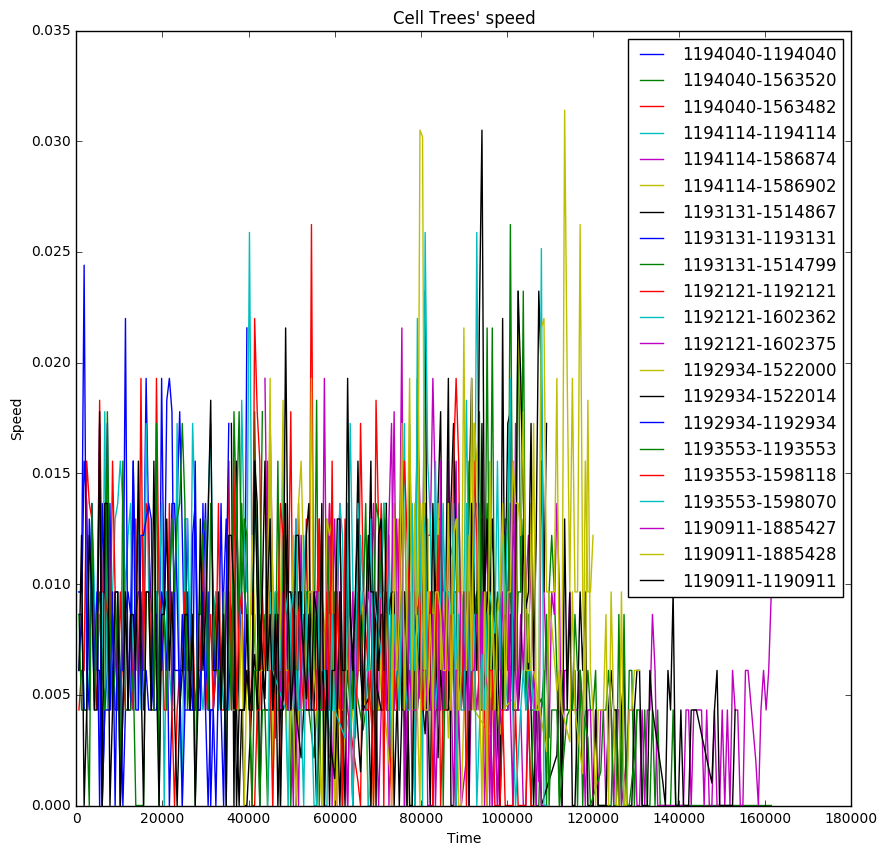

In [221]:
for tr in tree_deathaftertreatment:
    t_tree = tree_unpruned[tr]
    t_branch = branch_unpruned[tr]
    t_time = svals_unpruned['POSITION_T'][tr]
    t_x = svals_unpruned['POSITION_X'][tr]
    t_y = svals_unpruned['POSITION_Y'][tr]
    for br in t_tree:
        br_time = np.array(t_time[br])
        br_x = np.array(t_x[br])
        br_y = np.array(t_y[br])
    
        br_mvmt = []
    
        br_time_2 = br_time[1:]
        br_time_1 = br_time[:-1]
        br_x_2 = br_x[1:]
        br_x_1 = br_x[:-1]
        br_y_2 = br_y[1:]
        br_y_1 = br_y[:-1]
    
        
        speed = np.sqrt((br_x_2 - br_x_1)**2 + (br_y_2 - br_y_1)**2) / (br_time_2 - br_time_1)
        
        pt.plot(br_time_2, speed, label="%d-%d" % (tr, br))
    
    #     print(t_time_br)
    #     print(t_x_br)
    #     print(t_y_br)
    #     print("#" * 10)

pt.title("Cell Trees' speed")
pt.ylabel("Speed")
pt.xlabel("Time")
pt.legend(loc='best')
pt.gcf().set_size_inches(10, 10)

### X. Delete Variables

In [68]:
delete_all_variables()

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
